# IMPORTS

In [1]:
import os
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
aspect_accuracies = manager.list()
aspect_f1_micros = manager.list()
aspect_f1_macros = manager.list()
sentiment_accuracies = manager.list()
sentiment_f1_micros = manager.list()
sentiment_f1_macros = manager.list()
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()

# Non shared resources
epochs = 10
batch_size = 16
sequence_length = 48

aspect_list = ['fuel', 'machine', 'others', 'part', 'price', 'service']
aspect_mapping = {'fuel': 0, 'machine': 1, 'others': 2, 'part': 3, 'price': 4, 'service': 5 }
label_mapping = {"negative": 0, "neutral": 1, 'positive': 2}
ignored_keys = ['labels', 'ori_text', 'ori_label', 'ori_indices', 'aspect']

# LOAD AND PREPROCESS DATA

In [6]:
train_data = pd.read_csv('/kaggle/input/casa-dataset/train_preprocess.csv', encoding='latin-1')
val_data = pd.read_csv('/kaggle/input/casa-dataset/valid_preprocess.csv', encoding='latin-1')
test_data = pd.read_csv('/kaggle/input/casa-dataset/test_preprocess.csv', encoding='latin-1')

data = pd.concat([train_data, val_data, test_data], ignore_index=True)

data.head()

,sentence,fuel,machine,others,part,price,service
0,Saya memakai Honda Jazz GK5 tahun 2014 ( perta...,neutral,neutral,positive,neutral,neutral,neutral
1,Avanza kenapa jadi boros bensin begini dah ah....,negative,neutral,neutral,neutral,neutral,neutral
2,"saran ku dan pengalaman ku , mending beli mobi...",positive,positive,neutral,neutral,neutral,neutral
3,Dari segi harga juga pajero lebih mahal 30 jut...,neutral,neutral,neutral,neutral,positive,neutral
4,Kalo menurut gw enak pajero si,neutral,neutral,positive,neutral,neutral,neutral


In [7]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

In [8]:
train_labels = train_data.columns[1:]
val_labels = val_data.columns[1:]

# Extract features and labels for training and validation
X_train = train_data['sentence'].values
y_train = train_data[train_labels].values
X_val = val_data['sentence'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(864,) (864, 6)
(216,) (216, 6)


# BUILD DATASET & DATALOADERS

In [9]:
class AspectDetectionDataset(Dataset):
    def __init__(self, texts, labels, label_mapping, tokenizer, max_length=sequence_length, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float
        self.label_mapping = label_mapping

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        
        original_labels = [self.label_mapping[label] for label in self.labels[idx]]
        encoded_labels = [1 if label == 1 else 0 for label in original_labels]
        
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['ori_indices'] = idx
        item['ori_text'] = self.texts[idx]
        item['ori_label'] = torch.tensor(original_labels, dtype=torch.float)
        item['labels'] = torch.tensor(encoded_labels, dtype=torch.float if self.use_float else torch.long)
        
        return item

In [10]:
class SentimentAnalysisDataset(Dataset):
    def __init__(self, texts, labels, aspects, indices, label_mapping, tokenizer, max_length=96, use_float=True):
        self.texts = texts
        self.labels = labels
        self.aspects = aspects
        self.indices = indices
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float
        self.label_mapping = label_mapping

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = aspect_token + ' ' + self.aspects[idx] + ' ' + review_token + ' ' + self.texts[idx] 
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')

        if isinstance(self.labels[idx], str):
            self.labels[idx] = self.label_mapping[self.labels[idx]]
        elif torch.is_tensor(self.labels[idx]):
            self.labels[idx] = int(self.labels[idx].item())

        encoded_label = 1 if self.labels[idx] == 2 else self.labels[idx]
        one_hot_label = F.one_hot(torch.tensor(encoded_label, dtype=torch.long), num_classes=2).float()

        item = {key: val.squeeze() for key, val in encoding.items()}
        item['aspect'] = self.aspects[idx]
        item['labels'] = one_hot_label
        item['ori_indices'] = self.indices[idx]
        item['ori_text'] = self.texts[idx]
        item['ori_label'] = torch.tensor(self.labels[idx], dtype=torch.long)

        return item

In [11]:
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
review_token = '[REVIEW]'
aspect_token = '[ASPECT]'
special_tokens_dict = {'additional_special_tokens': [review_token, aspect_token]}
num_added_tokens = tokenizer.add_special_tokens(special_tokens_dict)

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [12]:
def build_aspect_dataset(X_train, y_train, X_val, y_val, sequence_length, num_workers=4):
    train_dataset = AspectDetectionDataset(X_train, y_train, label_mapping, tokenizer, max_length=sequence_length)
    val_dataset = AspectDetectionDataset(X_val, y_val, label_mapping, tokenizer, max_length=sequence_length)
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers,
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers, 
    )

    return train_loader, val_loader, train_dataset, val_dataset

In [13]:
def build_sentiment_dataset(device, train_dataset, val_dataset, aspect_detection_model, tokenizer, max_length=sequence_length):
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )

    aspect_detection_model.to(device)
    aspect_detection_model.eval()

    train_data = []
    train_labels = []
    train_aspects = []
    train_indices = []

    val_data = []
    val_labels = []
    val_aspects = []
    val_indices = []

    # Transform train set
    start_time = time.time()
    with torch.no_grad():
        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels'].to(device)
            
            outputs = aspect_detection_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            for i in range(len(preds)):
                for j in range(len(preds[i])):
                    if int(preds[i][j]) != 1:
                        train_aspects.append(aspect_list[j])
                        train_data.append(batch['ori_text'][i])
                        train_labels.append(batch['ori_label'][i][j])
                        train_indices.append(batch['ori_indices'][i])
            
        # Transform validation set
        for batch in val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels'].to(device)
            
            outputs = aspect_detection_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            for i in range(len(preds)):
                for j in range(len(preds[i])):
                    if int(preds[i][j]) != 1:
                        val_aspects.append(aspect_list[j])
                        val_data.append(batch['ori_text'][i])
                        val_labels.append(batch['ori_label'][i][j])
                        val_indices.append(batch['ori_indices'][i])

    train_dataset = SentimentAnalysisDataset(train_data, train_labels, train_aspects, train_indices, label_mapping, tokenizer, max_length=max_length)
    val_dataset = SentimentAnalysisDataset(val_data, val_labels, val_aspects, val_indices, label_mapping, tokenizer, max_length=max_length)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4, 
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )

    return train_loader, val_loader, train_dataset, val_dataset

# TRAIN THE MODEL

In [14]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 25

In [15]:
def compute_metrics(p, label, classes):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    hamming_accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        labels=label,
        target_names=classes,
        zero_division=0
    ) 

    return {
        'accuracy': hamming_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [16]:
def compute_metrics_overall(p, classes):
    preds = torch.tensor(p.predictions)
    labels = torch.tensor(p.label_ids)

    # Ensure it's in the correct shape
    if preds.shape != labels.shape:
        raise ValueError("Shape mismatch: predictions and labels must have the same shape.")

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    hamming_accuracy = (preds == labels).float().mean().item()

    # Compute per-label (column-wise) precision, recall, F1
    precision_list, recall_list, f1_micro_list, f1_macro_list = [], [], [], []
    
    for i in range(labels.shape[1]):  # Loop through each column (multi-output)
        prec, rec, f1_micro, _ = precision_recall_fscore_support(
            labels[:, i], preds[:, i], average='micro', zero_division=0
        )
        _, _, f1_macro, _ = precision_recall_fscore_support(
            labels[:, i], preds[:, i], average='macro', zero_division=0
        )

        precision_list.append(prec)
        recall_list.append(rec)
        f1_micro_list.append(f1_micro)
        f1_macro_list.append(f1_macro)

    # Compute average metrics across all outputs
    precision = sum(precision_list) / len(precision_list)
    recall = sum(recall_list) / len(recall_list)
    f1_micro = sum(f1_micro_list) / len(f1_micro_list)
    f1_macro = sum(f1_macro_list) / len(f1_macro_list)

    # Generate classification report per output
    reports = [classification_report(labels[:, i], preds[:, i], target_names=classes, zero_division=0) for i in range(labels.shape[1])]

    return {
        'accuracy': hamming_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'reports': reports  # Returns list of reports, one for each output label
    }


In [17]:
def train_model(current_train_size, train_indices, aspect_metrics, sentiment_metrics, metrics, trials, seed, filename):
    set_seed(seed)
    
    accelerator = Accelerator(mixed_precision='fp16')
    device = accelerator.device
    
    aspect_model = BertForSequenceClassification.from_pretrained(
        'indobenchmark/indobert-base-p1',
        num_labels=len(train_labels),
        problem_type="multi_label_classification"
    )

    # Freeze the first few layers of the encoder
    for name, param in aspect_model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define optimizer and loss function
    aspect_optimizer = torch.optim.AdamW(aspect_model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    aspect_train_loader, aspect_val_loader, aspect_train_dataset, aspect_val_dataset = build_aspect_dataset(current_X_train, current_y_train, X_val, y_val, sequence_length)

    # Prepare everything with Accelerator
    aspect_model, aspect_optimizer, aspect_train_loader, aspect_val_loader = accelerator.prepare(
        aspect_model, aspect_optimizer, aspect_train_loader, aspect_val_loader
    )

    aspect_result = None
    start_time = time.time()

    nearest_cp = current_train_size
    if nearest_cp not in checkpoints:
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
    percentage = math.ceil(nearest_cp / total_data * 100)

    # ASPECT DETECTION
    accelerator.print("ASPECT DETECTION")
    for epoch in range(epochs):
        aspect_model.train()
        epoch_loss = 0

        for batch in aspect_train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels']
        
            aspect_optimizer.zero_grad()
            outputs = aspect_model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            aspect_optimizer.step()
        
            epoch_loss += loss.item()
            
        aspect_model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in aspect_val_loader:
                inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
                labels = batch['labels']
                
                outputs = aspect_model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(
            type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}),
            None,
            ['fuel', 'machine', 'others', 'part', 'price', 'service']
        )

        if aspect_result is None or result['f1_micro'] >= aspect_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(aspect_model)
            unwrapped_model.save_pretrained(
                f'{filename}-aspect-{trials + 1}-model-{percentage}',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            aspect_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(aspect_train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    accelerator.print(f"\nAspect detection accuracy: {round(aspect_result['accuracy'], 4)}, F1 Micro: {round(aspect_result['f1_micro'], 4)}, F1 Macro: {round(aspect_result['f1_macro'], 4)}")
    accelerator.print(aspect_result['report'])

    best_aspect_model = BertForSequenceClassification.from_pretrained(f'{filename}-aspect-{trials + 1}-model-{percentage}')
    best_aspect_model = accelerator.prepare(best_aspect_model)

    # SENTIMENT ANALYSIS ON NON NEUTRAL ASPECTS
    accelerator.print("--------------------------------------------------")
    accelerator.print("SENTIMENT ANALYSIS")

    sentiment_model = BertForSequenceClassification.from_pretrained(
        'indobenchmark/indobert-base-p1',
        num_labels=2,
    )
    sentiment_optimizer = torch.optim.AdamW(sentiment_model.parameters(), lr=2e-5, weight_decay=0.01)

    for name, param in sentiment_model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    accelerator.wait_for_everyone()
    sentiment_train_loader, sentiment_val_loader, sentiment_train_dataset, sentiment_val_dataset = build_sentiment_dataset(
        device, aspect_train_dataset, aspect_val_dataset, best_aspect_model, tokenizer, max_length=sequence_length
    )
    sentiment_model, sentiment_optimizer, sentiment_train_loader, sentiment_val_loader = accelerator.prepare(
        sentiment_model, sentiment_optimizer, sentiment_train_loader, sentiment_val_loader
    )
    sentiment_result = None

    for epoch in range(epochs):
        sentiment_model.train()
        epoch_loss = 0
        
        for batch in sentiment_train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels']
        
            sentiment_optimizer.zero_grad()
            outputs = sentiment_model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            sentiment_optimizer.step()
        
            epoch_loss += loss.item()

        sentiment_model.eval()
        sentiment_val_outputs = []
        
        with torch.no_grad():
            for batch in sentiment_val_loader:
                inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
                
                outputs = sentiment_model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                for i in range(len(preds)):
                    val_output = {
                        'label': batch['labels'][i],
                        'aspect': batch['aspect'][i],
                        'ori_indices': batch['ori_indices'][i],
                        'pred': np.argmax(preds[i].cpu().numpy()),
                    }
                    sentiment_val_outputs.append(val_output)

        sentiment_val_outputs = accelerator.gather_for_metrics(sentiment_val_outputs)
        unique_val_outputs = {(x['ori_indices'].item(), x['aspect']): x for x in sentiment_val_outputs}
        sentiment_val_outputs = list(unique_val_outputs.values())

        result = compute_metrics(
            type('EvalOutput', (object,), {'predictions': [item['pred'] for item in sentiment_val_outputs], 'label_ids': [np.argmax(item['label'].cpu().numpy()) for item in sentiment_val_outputs]}),
            [0, 1],
            ['negative', 'positive']
        )

        if sentiment_result is None or result['f1_micro'] >= sentiment_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            sentiment_result = result
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(sentiment_model)
            unwrapped_model.save_pretrained(
                 f'{filename}-sentiment-{trials + 1}-model-{percentage}',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(sentiment_train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")
    
    end_time = time.time()
    duration = end_time - start_time

    accelerator.print(f"\nSentiment analysis accuracy: {round(sentiment_result['accuracy'], 4)}, F1 Micro: {round(sentiment_result['f1_micro'], 4)}, F1 Macro: {round(sentiment_result['f1_macro'], 4)}")
    accelerator.print(sentiment_result['report'])

    accelerator.wait_for_everyone()
    best_sentiment_model = BertForSequenceClassification.from_pretrained( f'{filename}-sentiment-{trials + 1}-model-{percentage}')
    best_sentiment_model = accelerator.prepare(best_sentiment_model)

    # Compute overall metrics
    aspect_labels = []
    aspect_indices = []
    aspect_preds = []

    aspect_outputs = {}
    sentiment_outputs = []
    
    best_aspect_model.eval()
    best_sentiment_model.eval()

    with torch.no_grad():
        for batch in aspect_val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            outputs = best_aspect_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            aspect_indices.append(accelerator.gather(batch['ori_indices']))
            aspect_labels.append(accelerator.gather(batch['ori_label']))
            aspect_preds.append(accelerator.gather(preds))

        aspect_indices = torch.cat(aspect_indices).cpu().numpy()
        aspect_labels = torch.cat(aspect_labels).cpu().numpy()
        aspect_preds = torch.cat(aspect_preds).cpu().numpy()

        accelerator.wait_for_everyone()
        aspect_outputs = [
            {'ori_indices': aspect_indices[i], 
             'ori_labels': aspect_labels[i], 
             'pred': aspect_preds[i]}
            for i in range(len(aspect_preds))
        ]
        aspect_outputs = {x['ori_indices'].item(): x for x in aspect_outputs}
    
        for batch in sentiment_val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            outputs = best_sentiment_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()
    
            for i in range(len(preds)):
                output = {
                    'aspect': batch['aspect'][i],
                    'ori_indices': batch['ori_indices'][i],
                    'pred': np.argmax(preds[i].cpu().numpy()),
                }
                sentiment_outputs.append(output)

        sentiment_outputs = accelerator.gather_for_metrics(sentiment_outputs)
        sentiment_outputs = {(x['ori_indices'].item(), x['aspect']): x for x in sentiment_outputs}

    # Replcae non neutral aspect to its predicted sentiment
    accelerator.wait_for_everyone()
    if accelerator.is_main_process:
        i = -1
        for (ori_index, aspect), value in sentiment_outputs.items():
            aspect = aspect_mapping[aspect]
            aspect_outputs[ori_index]['pred'][aspect] = 2 if value['pred'] == 1.0 else value['pred']

        result = compute_metrics_overall(
            type('EvalOutput', (object,), {'predictions': [output['pred'] for output in aspect_outputs.values()], 'label_ids': [output['ori_labels'] for output in aspect_outputs.values()]}),
            ['negative', 'neutral', 'positive'],
        )

        accelerator.print("--------------------------------------------------")
        accelerator.print(f"Iteration {current_train_size}: Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")
        accelerator.print("--------------------------------------------------")
        for i in range(len(train_labels)):
            accelerator.print(f"Aspect {aspect_list[i]} report:")
            accelerator.print(result['reports'][i])
       
        
        aspect_metrics[0].append(aspect_result['accuracy'])
        aspect_metrics[1].append(aspect_result['f1_micro'])
        aspect_metrics[2].append(aspect_result['f1_macro'])
        sentiment_metrics[0].append(sentiment_result['accuracy'])
        sentiment_metrics[1].append(sentiment_result['f1_micro'])
        sentiment_metrics[2].append(sentiment_result['f1_macro'])
        metrics[0].append(current_train_size)
        metrics[1].append(result['accuracy'])
        metrics[2].append(result['f1_micro'])
        metrics[3].append(result['f1_macro'])
        
    accelerator.print(f"Total train time: {duration} s")
    accelerator.end_training()
    return

# PLOT THE RESULTS

In [18]:
def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [19]:
def random_sampling(current_train_size, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, filename, n_samples=min_increment):
    start_time = time.time()
    
    nearest_cp = 0
    arrived_at_cp = False
    for cp in checkpoints:
        if cp > current_train_size:
            nearest_cp = cp
            break

    num_of_candidates = math.ceil(0.1 * len(remaining_indices))

    if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
        num_of_candidates = n_samples
    elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
        num_of_candidates = max(n_samples, num_of_candidates)
    else:
        num_of_candidates = nearest_cp - current_train_size
        arrived_at_cp = True

    random_indices = random.sample(range(len(X_pool)), num_of_candidates)

    if arrived_at_cp:
        temp = train_indices.copy()
        temp.extend([remaining_indices[i] for i in random_indices])
            
        # Save acquired data up to checkpoint
        acquired_data = pd.DataFrame({
            'processed_text': [X_train[i] for i in temp],
            'fuel': [y_train[i][0] for i in temp],
            'machine': [y_train[i][1] for i in temp],
            'others': [y_train[i][2] for i in temp],
            'part': [y_train[i][3] for i in temp],
            'price': [y_train[i][4] for i in temp],
            'service': [y_train[i][5] for i in temp],
        })

        acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)

    end_time = time.time() 
    duration = end_time - start_time

    sampling_dur.append(duration)
    for i in random_indices:
        new_samples.append(remaining_indices[i])
        
    print("Nearest checkpoint:", nearest_cp)
    print("Acquired samples:", len(random_indices))
    print(f"Sampling duration: {duration} seconds")

# MAIN LOOP

In [20]:
def active_learning(seed, i, init_size):
    aspect_accuracies = manager.list()
    aspect_f1_micros = manager.list()
    aspect_f1_macros = manager.list()
    sentiment_accuracies = manager.list()
    sentiment_f1_micros = manager.list()
    sentiment_f1_macros = manager.list()
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()
    filename = f'casa-random-init-{init_size}'

    set_seed(seed)
    
    print("===============================================")
    print("Init Size: {}".format(init_size))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (
            current_train_size, 
            train_indices, 
            (aspect_accuracies, aspect_f1_micros, aspect_f1_macros), 
            (sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros),
            (data_used, accuracies, f1_micros, f1_macros), 
            i,
            seed,
            filename
        )
        notebook_launcher(train_model, args, num_processes=2)
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        random_sampling(
            current_train_size, 
            [X_train[i] for i in remaining_indices], 
            train_indices, 
            remaining_indices, 
            sampling_dur, 
            new_samples, 
            i,
            filename
        )
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (
        current_train_size, 
        train_indices, 
        (aspect_accuracies, aspect_f1_micros, aspect_f1_macros), 
        (sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros),
        (data_used, accuracies, f1_micros, f1_macros), 
        i,
        seed,
        filename
    )
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    aspect_accuracies, aspect_f1_micros, aspect_f1_macros = list(aspect_accuracies), list(aspect_f1_micros), list(aspect_f1_macros)
    sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros = list(sentiment_accuracies), list(sentiment_f1_micros), list(sentiment_f1_macros)
    
    end_time = time.time()
    duration = end_time - start_time
    
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Aspect Accuracy': aspect_accuracies,
        'Aspect F1 Micro': aspect_f1_micros,
        'Aspect F1 Macro': aspect_f1_macros,
        'Sentiment Accuracy': sentiment_accuracies,
        'Sentiment F1 Micro': sentiment_f1_micros,
        'Sentiment F1 Macro': sentiment_f1_macros,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

Init Size: 1
Random seed: 81
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6716, Accuracy: 0.6763, F1 Micro: 0.7845, F1 Macro: 0.6875
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.623, Accuracy: 0.724, F1 Micro: 0.8277, F1 Macro: 0.7588
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5676, Accuracy: 0.7478, F1 Micro: 0.8485, F1 Macro: 0.8168
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.5258, Accuracy: 0.776, F1 Micro: 0.8712, F1 Macro: 0.865
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4874, Accuracy: 0.7932, F1 Micro: 0.884, F1 Macro: 0.8824
Epoch 6/10, Train Loss: 0.453, Accuracy: 0.7902, F1 Micro: 0.8826, F1 Macro: 0.8811
Epoch 7/10, Train Loss: 0.4214, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 8/10, Train Loss: 0.4196, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 9/10, Train Loss: 0.3868, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Epoch 10/10, Train Loss: 0.3569, Accuracy: 0.7917, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6232, Accuracy: 0.7778, F1 Micro: 0.7778, F1 Macro: 0.4375
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4977, Accuracy: 0.8889, F1 Micro: 0.8889, F1 Macro: 0.4706
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3777, Accuracy: 0.8889, F1 Micro: 0.8889, F1 Macro: 0.4706
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2928, Accuracy: 0.8889, F1 Micro: 0.8889, F1 Macro: 0.4706
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2176, Accuracy: 0.8889, F1 Micro: 0.8889, F1 Macro: 0.4706
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1723, Accuracy: 0.8889, F1 Micro: 0.8889, F1 Macro: 0.4706
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1318, Accuracy: 0.8889, F1 Micro: 0.8889, F1 Macro: 0.4706
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1066, Accuracy: 0.8889, F1 Micro: 0.8889, F1 Macro: 0.4706
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6418, Accuracy: 0.724, F1 Micro: 0.8301, F1 Macro: 0.7528
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5567, Accuracy: 0.7917, F1 Micro: 0.883, F1 Macro: 0.8814
Epoch 3/10, Train Loss: 0.5167, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Epoch 4/10, Train Loss: 0.4822, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Epoch 5/10, Train Loss: 0.5017, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4354, Accuracy: 0.7924, F1 Micro: 0.8836, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4449, Accuracy: 0.7984, F1 Micro: 0.8864, F1 Macro: 0.8848
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.4093, Accuracy: 0.8006, F1 Micro: 0.8874, F1 Macro: 0.8859
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3785, Accuracy: 0.8147, F1 Micro: 0.8941, F1 Macro: 0.8923
Higher F1 achieved, sav

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6271, Accuracy: 0.8061, F1 Micro: 0.8061, F1 Macro: 0.4463
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.6017, Accuracy: 0.8061, F1 Micro: 0.8061, F1 Macro: 0.4463
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5424, Accuracy: 0.8061, F1 Micro: 0.8061, F1 Macro: 0.4463
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4962, Accuracy: 0.8061, F1 Micro: 0.8061, F1 Macro: 0.4463
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.5021, Accuracy: 0.8061, F1 Micro: 0.8061, F1 Macro: 0.4463
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4154, Accuracy: 0.8061, F1 Micro: 0.8061, F1 Macro: 0.4463
Epoch 7/10, Train Loss: 0.4146, Accuracy: 0.7959, F1 Micro: 0.7959, F1 Macro: 0.4432
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3207, Accuracy: 0.8265, F1 Micro: 0.8265, F1 Macro: 0.6103
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2434, Accuracy: 0.8571, F1 Mic

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6099, Accuracy: 0.7932, F1 Micro: 0.8839, F1 Macro: 0.8823
Epoch 2/10, Train Loss: 0.511, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 3/10, Train Loss: 0.4991, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4791, Accuracy: 0.7976, F1 Micro: 0.8861, F1 Macro: 0.8845
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4373, Accuracy: 0.8177, F1 Micro: 0.8959, F1 Macro: 0.8944
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3842, Accuracy: 0.8638, F1 Micro: 0.9189, F1 Macro: 0.917
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3343, Accuracy: 0.8847, F1 Micro: 0.9296, F1 Macro: 0.9264
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2737, Accuracy: 0.904, F1 Micro: 0.9411, F1 Macro: 0.9385
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2262, Accuracy: 0.9137, F1 Micro: 0.9465, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5886, Accuracy: 0.6923, F1 Micro: 0.6923, F1 Macro: 0.4091
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5116, Accuracy: 0.6923, F1 Micro: 0.6923, F1 Macro: 0.4091
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4442, Accuracy: 0.724, F1 Micro: 0.724, F1 Macro: 0.539
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3796, Accuracy: 0.8688, F1 Micro: 0.8688, F1 Macro: 0.8512
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2364, Accuracy: 0.914, F1 Micro: 0.914, F1 Macro: 0.9011
Epoch 6/10, Train Loss: 0.1662, Accuracy: 0.8959, F1 Micro: 0.8959, F1 Macro: 0.8843
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0966, Accuracy: 0.914, F1 Micro: 0.914, F1 Macro: 0.9003
Epoch 8/10, Train Loss: 0.0962, Accuracy: 0.8597, F1 Micro: 0.8597, F1 Macro: 0.8477
Epoch 9/10, Train Loss: 0.1323, Accuracy: 0.8869, F1 Micro: 0.8869, F1 Macro: 0.8717
Epoch 10/10, Train Loss: 0.0641, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5902, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5003, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4826, Accuracy: 0.7909, F1 Micro: 0.883, F1 Macro: 0.8814
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4287, Accuracy: 0.8497, F1 Micro: 0.9123, F1 Macro: 0.911
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.357, Accuracy: 0.8966, F1 Micro: 0.9363, F1 Macro: 0.9336
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2881, Accuracy: 0.9182, F1 Micro: 0.9496, F1 Macro: 0.9475
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.249, Accuracy: 0.9323, F1 Micro: 0.9581, F1 Macro: 0.9558
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1974, Accuracy: 0.9405, F1 Micro: 0.9631, F1 Macro: 0.9608
Epoch 9/10, Train Loss: 0.1666, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.63, Accuracy: 0.6923, F1 Micro: 0.6923, F1 Macro: 0.4091
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5377, Accuracy: 0.7895, F1 Micro: 0.7895, F1 Macro: 0.6877
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2982, Accuracy: 0.9109, F1 Micro: 0.9109, F1 Macro: 0.8976
Epoch 4/10, Train Loss: 0.1707, Accuracy: 0.8623, F1 Micro: 0.8623, F1 Macro: 0.8528
Epoch 5/10, Train Loss: 0.1419, Accuracy: 0.9069, F1 Micro: 0.9069, F1 Macro: 0.8877
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0885, Accuracy: 0.915, F1 Micro: 0.915, F1 Macro: 0.9056
Epoch 7/10, Train Loss: 0.1161, Accuracy: 0.9109, F1 Micro: 0.9109, F1 Macro: 0.899
Epoch 8/10, Train Loss: 0.0566, Accuracy: 0.9028, F1 Micro: 0.9028, F1 Macro: 0.8924
Epoch 9/10, Train Loss: 0.0584, Accuracy: 0.9069, F1 Micro: 0.9069, F1 Macro: 0.894
Epoch 10/10, Train Loss: 0.096, Accuracy: 0.8947, F1 Micro: 0.8947, F1 Macro: 0.8853

Sentiment analysis accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5682, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4888, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4525, Accuracy: 0.8065, F1 Micro: 0.8908, F1 Macro: 0.8893
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3865, Accuracy: 0.8862, F1 Micro: 0.9319, F1 Macro: 0.9304
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3087, Accuracy: 0.9174, F1 Micro: 0.9488, F1 Macro: 0.9461
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.241, Accuracy: 0.9293, F1 Micro: 0.9561, F1 Macro: 0.954
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2088, Accuracy: 0.9472, F1 Micro: 0.9671, F1 Macro: 0.9654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.164, Accuracy: 0.9531, F1 Micro: 0.9708, F1 Macro: 0.9696
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6063, Accuracy: 0.6914, F1 Micro: 0.6914, F1 Macro: 0.4088
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4881, Accuracy: 0.875, F1 Micro: 0.875, F1 Macro: 0.8591
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2735, Accuracy: 0.9023, F1 Micro: 0.9023, F1 Macro: 0.8915
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.172, Accuracy: 0.9102, F1 Micro: 0.9102, F1 Macro: 0.8996
Epoch 5/10, Train Loss: 0.1206, Accuracy: 0.9062, F1 Micro: 0.9062, F1 Macro: 0.8937
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1353, Accuracy: 0.9141, F1 Micro: 0.9141, F1 Macro: 0.9042
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.104, Accuracy: 0.9375, F1 Micro: 0.9375, F1 Macro: 0.9278
Epoch 8/10, Train Loss: 0.1033, Accuracy: 0.918, F1 Micro: 0.918, F1 Macro: 0.9073
Epoch 9/10, Train Loss: 0.1086, Accuracy: 0.9141, F1 Micro: 0.9141, F1 Macro: 0.9037
Epoch 10/10, Train Loss: 0.0713, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5531, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4798, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4207, Accuracy: 0.8467, F1 Micro: 0.9112, F1 Macro: 0.9098
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3283, Accuracy: 0.9174, F1 Micro: 0.9486, F1 Macro: 0.9461
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2498, Accuracy: 0.933, F1 Micro: 0.9588, F1 Macro: 0.957
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2075, Accuracy: 0.9457, F1 Micro: 0.9662, F1 Macro: 0.9641
Epoch 7/10, Train Loss: 0.1543, Accuracy: 0.942, F1 Micro: 0.9635, F1 Macro: 0.9609
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.126, Accuracy: 0.9561, F1 Micro: 0.9725, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1005, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6173, Accuracy: 0.676, F1 Micro: 0.676, F1 Macro: 0.4033
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4112, Accuracy: 0.892, F1 Micro: 0.892, F1 Macro: 0.8793
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2341, Accuracy: 0.932, F1 Micro: 0.932, F1 Macro: 0.924
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1756, Accuracy: 0.932, F1 Micro: 0.932, F1 Macro: 0.9231
Epoch 5/10, Train Loss: 0.1138, Accuracy: 0.916, F1 Micro: 0.916, F1 Macro: 0.9077
Epoch 6/10, Train Loss: 0.1179, Accuracy: 0.916, F1 Micro: 0.916, F1 Macro: 0.9004
Epoch 7/10, Train Loss: 0.1012, Accuracy: 0.904, F1 Micro: 0.904, F1 Macro: 0.8953
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0879, Accuracy: 0.948, F1 Micro: 0.948, F1 Macro: 0.9408
Epoch 9/10, Train Loss: 0.0913, Accuracy: 0.896, F1 Micro: 0.896, F1 Macro: 0.8882
Epoch 10/10, Train Loss: 0.0549, Accuracy: 0.904, F1 Micro: 0.904, F1 Macro: 0.8963

Sent

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5641, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5024, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4129, Accuracy: 0.8936, F1 Micro: 0.9362, F1 Macro: 0.935
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3219, Accuracy: 0.9159, F1 Micro: 0.9476, F1 Macro: 0.9446
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2319, Accuracy: 0.942, F1 Micro: 0.964, F1 Macro: 0.9621
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1822, Accuracy: 0.9457, F1 Micro: 0.9661, F1 Macro: 0.9639
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1485, Accuracy: 0.9598, F1 Micro: 0.9748, F1 Macro: 0.9733
Epoch 8/10, Train Loss: 0.1165, Accuracy: 0.9576, F1 Micro: 0.9734, F1 Macro: 0.9717
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0951, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5948, Accuracy: 0.7804, F1 Micro: 0.7804, F1 Macro: 0.6949
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3115, Accuracy: 0.8784, F1 Micro: 0.8784, F1 Macro: 0.8708
Epoch 3/10, Train Loss: 0.2317, Accuracy: 0.8431, F1 Micro: 0.8431, F1 Macro: 0.8361
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1755, Accuracy: 0.9451, F1 Micro: 0.9451, F1 Macro: 0.9386
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1601, Accuracy: 0.9451, F1 Micro: 0.9451, F1 Macro: 0.9367
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0938, Accuracy: 0.9451, F1 Micro: 0.9451, F1 Macro: 0.9367
Epoch 7/10, Train Loss: 0.0891, Accuracy: 0.9255, F1 Micro: 0.9255, F1 Macro: 0.9186
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0824, Accuracy: 0.9529, F1 Micro: 0.9529, F1 Macro: 0.9457
Epoch 9/10, Train Loss: 0.0949, Accuracy: 0.9176, F1 Micro: 0.9176, F1 Macro: 0.9105
Higher F1 achieved, saving model
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5451, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4767, Accuracy: 0.8065, F1 Micro: 0.8908, F1 Macro: 0.8894
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3721, Accuracy: 0.9152, F1 Micro: 0.9478, F1 Macro: 0.9454
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.269, Accuracy: 0.9382, F1 Micro: 0.9616, F1 Macro: 0.9597
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2002, Accuracy: 0.9546, F1 Micro: 0.9719, F1 Macro: 0.9708
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1622, Accuracy: 0.9561, F1 Micro: 0.9726, F1 Macro: 0.9711
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1238, Accuracy: 0.9583, F1 Micro: 0.9738, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0974, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9752
Epoch 9/10, Train Loss: 0.0848, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6039, Accuracy: 0.677, F1 Micro: 0.677, F1 Macro: 0.4037
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4068, Accuracy: 0.9183, F1 Micro: 0.9183, F1 Macro: 0.9105
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2102, Accuracy: 0.9339, F1 Micro: 0.9339, F1 Macro: 0.9236
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1712, Accuracy: 0.9416, F1 Micro: 0.9416, F1 Macro: 0.9331
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1533, Accuracy: 0.9572, F1 Micro: 0.9572, F1 Macro: 0.9515
Epoch 6/10, Train Loss: 0.1408, Accuracy: 0.9494, F1 Micro: 0.9494, F1 Macro: 0.9423
Epoch 7/10, Train Loss: 0.1108, Accuracy: 0.9494, F1 Micro: 0.9494, F1 Macro: 0.9434
Epoch 8/10, Train Loss: 0.0788, Accuracy: 0.9533, F1 Micro: 0.9533, F1 Macro: 0.9479
Epoch 9/10, Train Loss: 0.0571, Accuracy: 0.9222, F1 Micro: 0.9222, F1 Macro: 0.9149
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0754, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5459, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.459, Accuracy: 0.8222, F1 Micro: 0.8986, F1 Macro: 0.8974
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3555, Accuracy: 0.9137, F1 Micro: 0.946, F1 Macro: 0.9431
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2633, Accuracy: 0.9464, F1 Micro: 0.9667, F1 Macro: 0.9654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.201, Accuracy: 0.9546, F1 Micro: 0.9716, F1 Macro: 0.9706
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1499, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9753
Epoch 7/10, Train Loss: 0.1154, Accuracy: 0.9561, F1 Micro: 0.9723, F1 Macro: 0.9701
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0941, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9773
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0822, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5707, Accuracy: 0.6653, F1 Micro: 0.6653, F1 Macro: 0.3995
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3506, Accuracy: 0.9203, F1 Micro: 0.9203, F1 Macro: 0.9125
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2033, Accuracy: 0.9402, F1 Micro: 0.9402, F1 Macro: 0.9346
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.156, Accuracy: 0.9402, F1 Micro: 0.9402, F1 Macro: 0.9349
Epoch 5/10, Train Loss: 0.1469, Accuracy: 0.9004, F1 Micro: 0.9004, F1 Macro: 0.8939
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1552, Accuracy: 0.9602, F1 Micro: 0.9602, F1 Macro: 0.9558
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1006, Accuracy: 0.9641, F1 Micro: 0.9641, F1 Macro: 0.9603
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0963, Accuracy: 0.9641, F1 Micro: 0.9641, F1 Macro: 0.9601
Epoch 9/10, Train Loss: 0.0873, Accuracy: 0.9562, F1 Micro: 0.9562, F1 Macro: 0.9512
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5424, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4472, Accuracy: 0.8259, F1 Micro: 0.9004, F1 Macro: 0.8993
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3464, Accuracy: 0.9323, F1 Micro: 0.9581, F1 Macro: 0.9565
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2468, Accuracy: 0.942, F1 Micro: 0.9638, F1 Macro: 0.9622
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1917, Accuracy: 0.9546, F1 Micro: 0.9717, F1 Macro: 0.9704
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1368, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.977
Epoch 7/10, Train Loss: 0.106, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.976
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0866, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9784
Epoch 9/10, Train Loss: 0.0762, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5721, Accuracy: 0.6943, F1 Micro: 0.6943, F1 Macro: 0.4718
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3033, Accuracy: 0.9245, F1 Micro: 0.9245, F1 Macro: 0.9159
Epoch 3/10, Train Loss: 0.1654, Accuracy: 0.883, F1 Micro: 0.883, F1 Macro: 0.8753
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1509, Accuracy: 0.9321, F1 Micro: 0.9321, F1 Macro: 0.9255
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1182, Accuracy: 0.9358, F1 Micro: 0.9358, F1 Macro: 0.9294
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1264, Accuracy: 0.9434, F1 Micro: 0.9434, F1 Macro: 0.934
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1466, Accuracy: 0.9472, F1 Micro: 0.9472, F1 Macro: 0.9394
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0706, Accuracy: 0.9472, F1 Micro: 0.9472, F1 Macro: 0.9411
Epoch 9/10, Train Loss: 0.0666, Accuracy: 0.9396, F1 Micro: 0.9396, F1 Macro: 0.9331
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5408, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4628, Accuracy: 0.8214, F1 Micro: 0.8983, F1 Macro: 0.8969
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3526, Accuracy: 0.9286, F1 Micro: 0.9559, F1 Macro: 0.954
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2416, Accuracy: 0.9464, F1 Micro: 0.9667, F1 Macro: 0.9655
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1791, Accuracy: 0.9554, F1 Micro: 0.9723, F1 Macro: 0.9714
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1456, Accuracy: 0.9576, F1 Micro: 0.9734, F1 Macro: 0.9717
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1118, Accuracy: 0.9673, F1 Micro: 0.9795, F1 Macro: 0.9785
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0902, Accuracy: 0.9695, F1 Micro: 0.9809, F1 Macro: 0.98
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6047, Accuracy: 0.668, F1 Micro: 0.668, F1 Macro: 0.4005
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3472, Accuracy: 0.892, F1 Micro: 0.892, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1632, Accuracy: 0.924, F1 Micro: 0.924, F1 Macro: 0.9177
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1532, Accuracy: 0.936, F1 Micro: 0.936, F1 Macro: 0.9302
Epoch 5/10, Train Loss: 0.1517, Accuracy: 0.916, F1 Micro: 0.916, F1 Macro: 0.9086
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1349, Accuracy: 0.94, F1 Micro: 0.94, F1 Macro: 0.9333
Epoch 7/10, Train Loss: 0.0847, Accuracy: 0.912, F1 Micro: 0.912, F1 Macro: 0.9054
Epoch 8/10, Train Loss: 0.1043, Accuracy: 0.9, F1 Micro: 0.9, F1 Macro: 0.8937
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0919, Accuracy: 0.944, F1 Micro: 0.944, F1 Macro: 0.938
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.06

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5477, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4475, Accuracy: 0.84, F1 Micro: 0.9078, F1 Macro: 0.9066
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3389, Accuracy: 0.9323, F1 Micro: 0.9582, F1 Macro: 0.9562
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.236, Accuracy: 0.9494, F1 Micro: 0.9684, F1 Macro: 0.9668
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.18, Accuracy: 0.9546, F1 Micro: 0.9715, F1 Macro: 0.9694
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1278, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9734
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1047, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9765
Epoch 8/10, Train Loss: 0.0812, Accuracy: 0.9598, F1 Micro: 0.9746, F1 Macro: 0.9723
Epoch 9/10, Train Loss: 0.0692, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5439, Accuracy: 0.8517, F1 Micro: 0.8517, F1 Macro: 0.834
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3036, Accuracy: 0.9316, F1 Micro: 0.9316, F1 Macro: 0.9231
Epoch 3/10, Train Loss: 0.1998, Accuracy: 0.9011, F1 Micro: 0.9011, F1 Macro: 0.8943
Epoch 4/10, Train Loss: 0.1523, Accuracy: 0.9087, F1 Micro: 0.9087, F1 Macro: 0.902
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1624, Accuracy: 0.9468, F1 Micro: 0.9468, F1 Macro: 0.9409
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1296, Accuracy: 0.9506, F1 Micro: 0.9506, F1 Macro: 0.9447
Epoch 7/10, Train Loss: 0.1144, Accuracy: 0.943, F1 Micro: 0.943, F1 Macro: 0.9368
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1006, Accuracy: 0.9506, F1 Micro: 0.9506, F1 Macro: 0.945
Epoch 9/10, Train Loss: 0.0943, Accuracy: 0.9125, F1 Micro: 0.9125, F1 Macro: 0.9055
Epoch 10/10, Train Loss: 0.0803, Accuracy: 0.9125, F1 Micro: 0.9125, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5425, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4453, Accuracy: 0.8631, F1 Micro: 0.9197, F1 Macro: 0.9184
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3206, Accuracy: 0.9323, F1 Micro: 0.9577, F1 Macro: 0.9553
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.231, Accuracy: 0.9516, F1 Micro: 0.97, F1 Macro: 0.9685
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1654, Accuracy: 0.9591, F1 Micro: 0.9742, F1 Macro: 0.9722
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1185, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9742
Epoch 7/10, Train Loss: 0.106, Accuracy: 0.9613, F1 Micro: 0.9756, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0781, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9773
Epoch 9/10, Train Loss: 0.0705, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5232, Accuracy: 0.861, F1 Micro: 0.861, F1 Macro: 0.8459
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3287, Accuracy: 0.9305, F1 Micro: 0.9305, F1 Macro: 0.9225
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.225, Accuracy: 0.9498, F1 Micro: 0.9498, F1 Macro: 0.9439
Epoch 4/10, Train Loss: 0.1359, Accuracy: 0.9382, F1 Micro: 0.9382, F1 Macro: 0.9304
Epoch 5/10, Train Loss: 0.1516, Accuracy: 0.9382, F1 Micro: 0.9382, F1 Macro: 0.9291
Epoch 6/10, Train Loss: 0.1059, Accuracy: 0.9382, F1 Micro: 0.9382, F1 Macro: 0.9295
Epoch 7/10, Train Loss: 0.1319, Accuracy: 0.9459, F1 Micro: 0.9459, F1 Macro: 0.9398
Epoch 8/10, Train Loss: 0.1003, Accuracy: 0.9382, F1 Micro: 0.9382, F1 Macro: 0.9291
Epoch 9/10, Train Loss: 0.0719, Accuracy: 0.9112, F1 Micro: 0.9112, F1 Macro: 0.8941
Epoch 10/10, Train Loss: 0.0486, Accuracy: 0.9344, F1 Micro: 0.9344, F1 Macro: 0.9258

Sentiment analysis accuracy: 0.9498, F1 Micro: 0.949

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5404, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4394, Accuracy: 0.8973, F1 Micro: 0.9382, F1 Macro: 0.937
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3058, Accuracy: 0.939, F1 Micro: 0.9621, F1 Macro: 0.9604
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2169, Accuracy: 0.9516, F1 Micro: 0.97, F1 Macro: 0.9684
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1652, Accuracy: 0.9591, F1 Micro: 0.9744, F1 Macro: 0.9734
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1263, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0995, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9773
Epoch 8/10, Train Loss: 0.0796, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0633, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5396, Accuracy: 0.8674, F1 Micro: 0.8674, F1 Macro: 0.8504
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2642, Accuracy: 0.9394, F1 Micro: 0.9394, F1 Macro: 0.9318
Epoch 3/10, Train Loss: 0.1844, Accuracy: 0.9318, F1 Micro: 0.9318, F1 Macro: 0.9204
Epoch 4/10, Train Loss: 0.1587, Accuracy: 0.9242, F1 Micro: 0.9242, F1 Macro: 0.9166
Epoch 5/10, Train Loss: 0.1334, Accuracy: 0.928, F1 Micro: 0.928, F1 Macro: 0.921
Epoch 6/10, Train Loss: 0.12, Accuracy: 0.9091, F1 Micro: 0.9091, F1 Macro: 0.9013
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1167, Accuracy: 0.947, F1 Micro: 0.947, F1 Macro: 0.9393
Epoch 8/10, Train Loss: 0.0896, Accuracy: 0.9167, F1 Micro: 0.9167, F1 Macro: 0.9091
Epoch 9/10, Train Loss: 0.0895, Accuracy: 0.9015, F1 Micro: 0.9015, F1 Macro: 0.8936
Epoch 10/10, Train Loss: 0.0882, Accuracy: 0.9053, F1 Micro: 0.9053, F1 Macro: 0.8975

Sentiment analysis accuracy: 0.947, F1 Micro: 0.947, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5294, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4278, Accuracy: 0.8988, F1 Micro: 0.9376, F1 Macro: 0.9352
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2956, Accuracy: 0.9397, F1 Micro: 0.9626, F1 Macro: 0.9606
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2033, Accuracy: 0.9561, F1 Micro: 0.9728, F1 Macro: 0.9718
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1505, Accuracy: 0.9613, F1 Micro: 0.9758, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1141, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9745
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0905, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9764
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0739, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9765
Higher F1 achieved, saving model
Epoch 9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5231, Accuracy: 0.8783, F1 Micro: 0.8783, F1 Macro: 0.8634
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2014, Accuracy: 0.9011, F1 Micro: 0.9011, F1 Macro: 0.8934
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2063, Accuracy: 0.9506, F1 Micro: 0.9506, F1 Macro: 0.9437
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.168, Accuracy: 0.9544, F1 Micro: 0.9544, F1 Macro: 0.9488
Epoch 5/10, Train Loss: 0.1252, Accuracy: 0.9163, F1 Micro: 0.9163, F1 Macro: 0.9089
Epoch 6/10, Train Loss: 0.1188, Accuracy: 0.9316, F1 Micro: 0.9316, F1 Macro: 0.9248
Epoch 7/10, Train Loss: 0.0975, Accuracy: 0.9202, F1 Micro: 0.9202, F1 Macro: 0.9129
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.073, Accuracy: 0.9658, F1 Micro: 0.9658, F1 Macro: 0.9603
Epoch 9/10, Train Loss: 0.0968, Accuracy: 0.924, F1 Micro: 0.924, F1 Macro: 0.9089
Epoch 10/10, Train Loss: 0.0619, Accuracy: 0.962, F1 Micro: 0.962, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5284, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4154, Accuracy: 0.904, F1 Micro: 0.9417, F1 Macro: 0.9404
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2759, Accuracy: 0.9487, F1 Micro: 0.9683, F1 Macro: 0.9669
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.199, Accuracy: 0.9554, F1 Micro: 0.9721, F1 Macro: 0.9709
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1505, Accuracy: 0.9613, F1 Micro: 0.9758, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1087, Accuracy: 0.965, F1 Micro: 0.9782, F1 Macro: 0.9773
Epoch 7/10, Train Loss: 0.0828, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9757
Epoch 8/10, Train Loss: 0.0737, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.975
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0586, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5072, Accuracy: 0.8643, F1 Micro: 0.8643, F1 Macro: 0.8451
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2625, Accuracy: 0.9457, F1 Micro: 0.9457, F1 Macro: 0.9386
Epoch 3/10, Train Loss: 0.2014, Accuracy: 0.9186, F1 Micro: 0.9186, F1 Macro: 0.9046
Epoch 4/10, Train Loss: 0.1657, Accuracy: 0.9147, F1 Micro: 0.9147, F1 Macro: 0.9075
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1053, Accuracy: 0.9535, F1 Micro: 0.9535, F1 Macro: 0.948
Epoch 6/10, Train Loss: 0.109, Accuracy: 0.9341, F1 Micro: 0.9341, F1 Macro: 0.9273
Epoch 7/10, Train Loss: 0.0947, Accuracy: 0.938, F1 Micro: 0.938, F1 Macro: 0.931
Epoch 8/10, Train Loss: 0.0837, Accuracy: 0.9031, F1 Micro: 0.9031, F1 Macro: 0.8956
Epoch 9/10, Train Loss: 0.0852, Accuracy: 0.9341, F1 Micro: 0.9341, F1 Macro: 0.9261
Epoch 10/10, Train Loss: 0.0573, Accuracy: 0.9341, F1 Micro: 0.9341, F1 Macro: 0.9269

Sentiment analysis accuracy: 0.9535, F1 Micro: 0.9535,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.532, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4277, Accuracy: 0.8951, F1 Micro: 0.9339, F1 Macro: 0.9299
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2893, Accuracy: 0.9494, F1 Micro: 0.9686, F1 Macro: 0.9672
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.193, Accuracy: 0.9583, F1 Micro: 0.9741, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1447, Accuracy: 0.9665, F1 Micro: 0.9791, F1 Macro: 0.9779
Epoch 6/10, Train Loss: 0.1175, Accuracy: 0.9598, F1 Micro: 0.9748, F1 Macro: 0.9735
Epoch 7/10, Train Loss: 0.0858, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9779
Epoch 8/10, Train Loss: 0.0681, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Macro: 0.976
Epoch 9/10, Train Loss: 0.0575, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9778
Epoch 10/10, Train Loss: 0.0533, Accuracy: 0.965, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5318, Accuracy: 0.8629, F1 Micro: 0.8629, F1 Macro: 0.8495
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2716, Accuracy: 0.9435, F1 Micro: 0.9435, F1 Macro: 0.938
Epoch 3/10, Train Loss: 0.1853, Accuracy: 0.9315, F1 Micro: 0.9315, F1 Macro: 0.9249
Epoch 4/10, Train Loss: 0.1047, Accuracy: 0.9315, F1 Micro: 0.9315, F1 Macro: 0.9257
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.145, Accuracy: 0.9516, F1 Micro: 0.9516, F1 Macro: 0.9463
Epoch 6/10, Train Loss: 0.1066, Accuracy: 0.9395, F1 Micro: 0.9395, F1 Macro: 0.9341
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1038, Accuracy: 0.9516, F1 Micro: 0.9516, F1 Macro: 0.9453
Epoch 8/10, Train Loss: 0.0834, Accuracy: 0.9355, F1 Micro: 0.9355, F1 Macro: 0.9295
Epoch 9/10, Train Loss: 0.0923, Accuracy: 0.9274, F1 Micro: 0.9274, F1 Macro: 0.9215
Epoch 10/10, Train Loss: 0.0679, Accuracy: 0.9476, F1 Micro: 0.9476, F1 Macro: 0.9426

Sentiment analysis

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5273, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4, Accuracy: 0.907, F1 Micro: 0.9422, F1 Macro: 0.9394
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2725, Accuracy: 0.9516, F1 Micro: 0.9699, F1 Macro: 0.9686
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1786, Accuracy: 0.9576, F1 Micro: 0.9735, F1 Macro: 0.9724
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1419, Accuracy: 0.9658, F1 Micro: 0.9786, F1 Macro: 0.9776
Epoch 6/10, Train Loss: 0.1027, Accuracy: 0.9613, F1 Micro: 0.9755, F1 Macro: 0.9734
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0869, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9782
Epoch 8/10, Train Loss: 0.0727, Accuracy: 0.9658, F1 Micro: 0.9783, F1 Macro: 0.9766
Epoch 9/10, Train Loss: 0.0596, Accuracy: 0.965, F1 Micro: 0.9778, F1 Macro: 0.9762
Higher F1 achieved, savin

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5251, Accuracy: 0.8893, F1 Micro: 0.8893, F1 Macro: 0.8759
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2358, Accuracy: 0.9077, F1 Micro: 0.9077, F1 Macro: 0.8911
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1593, Accuracy: 0.9225, F1 Micro: 0.9225, F1 Macro: 0.9151
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1608, Accuracy: 0.9483, F1 Micro: 0.9483, F1 Macro: 0.9424
Epoch 5/10, Train Loss: 0.1193, Accuracy: 0.9299, F1 Micro: 0.9299, F1 Macro: 0.9188
Epoch 6/10, Train Loss: 0.1355, Accuracy: 0.8708, F1 Micro: 0.8708, F1 Macro: 0.8627
Epoch 7/10, Train Loss: 0.1193, Accuracy: 0.941, F1 Micro: 0.941, F1 Macro: 0.9338
Epoch 8/10, Train Loss: 0.0828, Accuracy: 0.9188, F1 Micro: 0.9188, F1 Macro: 0.9113
Epoch 9/10, Train Loss: 0.0901, Accuracy: 0.9299, F1 Micro: 0.9299, F1 Macro: 0.922
Epoch 10/10, Train Loss: 0.0663, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.9243

Sentiment analysis 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5295, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3979, Accuracy: 0.9211, F1 Micro: 0.9509, F1 Macro: 0.9488
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.269, Accuracy: 0.9405, F1 Micro: 0.9628, F1 Macro: 0.9606
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1817, Accuracy: 0.9613, F1 Micro: 0.9759, F1 Macro: 0.975
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1272, Accuracy: 0.9643, F1 Micro: 0.9777, F1 Macro: 0.9767
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0995, Accuracy: 0.9673, F1 Micro: 0.9795, F1 Macro: 0.9784
Epoch 7/10, Train Loss: 0.0781, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.978
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.066, Accuracy: 0.9695, F1 Micro: 0.9808, F1 Macro: 0.9797
Epoch 9/10, Train Loss: 0.0569, Accuracy: 0.9665, F1 Micro: 0.9788, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5295, Accuracy: 0.8885, F1 Micro: 0.8885, F1 Macro: 0.8744
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2695, Accuracy: 0.9462, F1 Micro: 0.9462, F1 Macro: 0.9405
Epoch 3/10, Train Loss: 0.1865, Accuracy: 0.9423, F1 Micro: 0.9423, F1 Macro: 0.9358
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1506, Accuracy: 0.95, F1 Micro: 0.95, F1 Macro: 0.9437
Epoch 5/10, Train Loss: 0.1433, Accuracy: 0.9385, F1 Micro: 0.9385, F1 Macro: 0.9327
Epoch 6/10, Train Loss: 0.0811, Accuracy: 0.9423, F1 Micro: 0.9423, F1 Macro: 0.9368
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1214, Accuracy: 0.9538, F1 Micro: 0.9538, F1 Macro: 0.949
Epoch 8/10, Train Loss: 0.0746, Accuracy: 0.9385, F1 Micro: 0.9385, F1 Macro: 0.9324
Epoch 9/10, Train Loss: 0.0609, Accuracy: 0.95, F1 Micro: 0.95, F1 Macro: 0.9449
Epoch 10/10, Train Loss: 0.0517, Accuracy: 0.9462, F1 Micro: 0.9462, F1 Macro: 0.9408

Sentiment analysis accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5295, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3996, Accuracy: 0.9085, F1 Micro: 0.943, F1 Macro: 0.9403
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2628, Accuracy: 0.9546, F1 Micro: 0.9718, F1 Macro: 0.9706
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1825, Accuracy: 0.9628, F1 Micro: 0.9768, F1 Macro: 0.976
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1251, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9767
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.103, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9774
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0788, Accuracy: 0.9688, F1 Micro: 0.9804, F1 Macro: 0.9794
Epoch 8/10, Train Loss: 0.0673, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9764
Epoch 9/10, Train Loss: 0.0511, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5036, Accuracy: 0.8933, F1 Micro: 0.8933, F1 Macro: 0.8793
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2313, Accuracy: 0.9486, F1 Micro: 0.9486, F1 Macro: 0.9438
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1664, Accuracy: 0.9526, F1 Micro: 0.9526, F1 Macro: 0.9474
Epoch 4/10, Train Loss: 0.1523, Accuracy: 0.9289, F1 Micro: 0.9289, F1 Macro: 0.9231
Epoch 5/10, Train Loss: 0.1488, Accuracy: 0.9486, F1 Micro: 0.9486, F1 Macro: 0.9426
Epoch 6/10, Train Loss: 0.1145, Accuracy: 0.9447, F1 Micro: 0.9447, F1 Macro: 0.939
Epoch 7/10, Train Loss: 0.0951, Accuracy: 0.9486, F1 Micro: 0.9486, F1 Macro: 0.9429
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0782, Accuracy: 0.9565, F1 Micro: 0.9565, F1 Macro: 0.9517
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0532, Accuracy: 0.9565, F1 Micro: 0.9565, F1 Macro: 0.9517
Epoch 10/10, Train Loss: 0.0531, Accuracy: 0.9051, F1 Micro: 0.9051, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.517, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3911, Accuracy: 0.9152, F1 Micro: 0.947, F1 Macro: 0.9443
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2529, Accuracy: 0.9539, F1 Micro: 0.9714, F1 Macro: 0.9702
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1705, Accuracy: 0.9635, F1 Micro: 0.9772, F1 Macro: 0.9761
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1305, Accuracy: 0.9658, F1 Micro: 0.9786, F1 Macro: 0.9776
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0985, Accuracy: 0.9688, F1 Micro: 0.9804, F1 Macro: 0.9793
Epoch 7/10, Train Loss: 0.0817, Accuracy: 0.965, F1 Micro: 0.9778, F1 Macro: 0.9762
Epoch 8/10, Train Loss: 0.061, Accuracy: 0.9688, F1 Micro: 0.9804, F1 Macro: 0.9792
Epoch 9/10, Train Loss: 0.0491, Accuracy: 0.9688, F1 Micro: 0.9803, F1 Macro: 0.9789
Epoch 10/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5274, Accuracy: 0.8725, F1 Micro: 0.8725, F1 Macro: 0.849
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2699, Accuracy: 0.9482, F1 Micro: 0.9482, F1 Macro: 0.9427
Epoch 3/10, Train Loss: 0.152, Accuracy: 0.9442, F1 Micro: 0.9442, F1 Macro: 0.9391
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1566, Accuracy: 0.9482, F1 Micro: 0.9482, F1 Macro: 0.9433
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1271, Accuracy: 0.9482, F1 Micro: 0.9482, F1 Macro: 0.943
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1045, Accuracy: 0.9522, F1 Micro: 0.9522, F1 Macro: 0.9475
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0707, Accuracy: 0.9602, F1 Micro: 0.9602, F1 Macro: 0.956
Epoch 8/10, Train Loss: 0.0957, Accuracy: 0.9442, F1 Micro: 0.9442, F1 Macro: 0.9391
Epoch 9/10, Train Loss: 0.0854, Accuracy: 0.9522, F1 Micro: 0.9522, F1 Macro: 0.9472
Epoch 10/10, Train Loss: 0.0486, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5273, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3712, Accuracy: 0.9278, F1 Micro: 0.955, F1 Macro: 0.9523
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2461, Accuracy: 0.9531, F1 Micro: 0.9708, F1 Macro: 0.9697
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.168, Accuracy: 0.9613, F1 Micro: 0.9758, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1163, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9777
Epoch 6/10, Train Loss: 0.0966, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9775
Epoch 7/10, Train Loss: 0.0784, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Macro: 0.9757
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0641, Accuracy: 0.9688, F1 Micro: 0.9804, F1 Macro: 0.9794
Epoch 9/10, Train Loss: 0.0544, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9746
Higher F1 achieved, sa

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4835, Accuracy: 0.8992, F1 Micro: 0.8992, F1 Macro: 0.8873
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2397, Accuracy: 0.9341, F1 Micro: 0.9341, F1 Macro: 0.9277
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1598, Accuracy: 0.9419, F1 Micro: 0.9419, F1 Macro: 0.9318
Epoch 4/10, Train Loss: 0.1705, Accuracy: 0.9302, F1 Micro: 0.9302, F1 Macro: 0.9232
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.137, Accuracy: 0.9574, F1 Micro: 0.9574, F1 Macro: 0.9522
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0958, Accuracy: 0.9574, F1 Micro: 0.9574, F1 Macro: 0.9522
Epoch 7/10, Train Loss: 0.0868, Accuracy: 0.9535, F1 Micro: 0.9535, F1 Macro: 0.9483
Epoch 8/10, Train Loss: 0.0644, Accuracy: 0.9496, F1 Micro: 0.9496, F1 Macro: 0.9441
Epoch 9/10, Train Loss: 0.0641, Accuracy: 0.938, F1 Micro: 0.938, F1 Macro: 0.9317
Epoch 10/10, Train Loss: 0.0784, Accuracy: 0.9457, F1 Micro: 0.9457, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5294, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3797, Accuracy: 0.9204, F1 Micro: 0.9501, F1 Macro: 0.9466
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2512, Accuracy: 0.9524, F1 Micro: 0.9704, F1 Macro: 0.9691
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1753, Accuracy: 0.9628, F1 Micro: 0.9768, F1 Macro: 0.9758
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1217, Accuracy: 0.9665, F1 Micro: 0.9791, F1 Macro: 0.9781
Epoch 6/10, Train Loss: 0.093, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9774
Epoch 7/10, Train Loss: 0.0792, Accuracy: 0.9628, F1 Micro: 0.9764, F1 Macro: 0.9743
Epoch 8/10, Train Loss: 0.0632, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.976
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0527, Accuracy: 0.968, F1 Micro: 0.9798, F1 Macro: 0.9784
Higher F1 achieved, savi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5237, Accuracy: 0.9042, F1 Micro: 0.9042, F1 Macro: 0.8943
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2346, Accuracy: 0.9042, F1 Micro: 0.9042, F1 Macro: 0.8853
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1347, Accuracy: 0.9119, F1 Micro: 0.9119, F1 Macro: 0.9042
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1548, Accuracy: 0.931, F1 Micro: 0.931, F1 Macro: 0.9229
Epoch 5/10, Train Loss: 0.1616, Accuracy: 0.9119, F1 Micro: 0.9119, F1 Macro: 0.905
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1267, Accuracy: 0.9349, F1 Micro: 0.9349, F1 Macro: 0.9277
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0864, Accuracy: 0.9464, F1 Micro: 0.9464, F1 Macro: 0.9389
Epoch 8/10, Train Loss: 0.082, Accuracy: 0.9387, F1 Micro: 0.9387, F1 Macro: 0.9318
Epoch 9/10, Train Loss: 0.0848, Accuracy: 0.931, F1 Micro: 0.931, F1 Macro: 0.9233
Epoch 10/10, Train Loss: 0.0685, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5207, Accuracy: 0.7932, F1 Micro: 0.8842, F1 Macro: 0.8827
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3711, Accuracy: 0.9323, F1 Micro: 0.9582, F1 Macro: 0.9563
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2344, Accuracy: 0.9568, F1 Micro: 0.9732, F1 Macro: 0.9722
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1675, Accuracy: 0.9576, F1 Micro: 0.9734, F1 Macro: 0.9719
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1191, Accuracy: 0.965, F1 Micro: 0.9778, F1 Macro: 0.9758
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0958, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.978
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0756, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9786
Epoch 8/10, Train Loss: 0.061, Accuracy: 0.9665, F1 Micro: 0.9788, F1 Macro: 0.977
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0489, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5216, Accuracy: 0.9231, F1 Micro: 0.9231, F1 Macro: 0.9155
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2411, Accuracy: 0.9462, F1 Micro: 0.9462, F1 Macro: 0.9402
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1693, Accuracy: 0.9538, F1 Micro: 0.9538, F1 Macro: 0.9479
Epoch 4/10, Train Loss: 0.1511, Accuracy: 0.9269, F1 Micro: 0.9269, F1 Macro: 0.9203
Epoch 5/10, Train Loss: 0.1061, Accuracy: 0.9385, F1 Micro: 0.9385, F1 Macro: 0.9324
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1001, Accuracy: 0.9577, F1 Micro: 0.9577, F1 Macro: 0.9524
Epoch 7/10, Train Loss: 0.094, Accuracy: 0.95, F1 Micro: 0.95, F1 Macro: 0.944
Epoch 8/10, Train Loss: 0.1039, Accuracy: 0.9538, F1 Micro: 0.9538, F1 Macro: 0.9469
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0541, Accuracy: 0.9577, F1 Micro: 0.9577, F1 Macro: 0.9521
Epoch 10/10, Train Loss: 0.0544, Accuracy: 0.9538, F1 Micro: 0.9538, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5146, Accuracy: 0.7924, F1 Micro: 0.8838, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3651, Accuracy: 0.9226, F1 Micro: 0.9514, F1 Macro: 0.9488
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.231, Accuracy: 0.9583, F1 Micro: 0.9741, F1 Macro: 0.9728
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1623, Accuracy: 0.9621, F1 Micro: 0.9763, F1 Macro: 0.975
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1203, Accuracy: 0.9665, F1 Micro: 0.9788, F1 Macro: 0.9773
Epoch 6/10, Train Loss: 0.0922, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9764
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0748, Accuracy: 0.9673, F1 Micro: 0.9793, F1 Macro: 0.9778
Epoch 8/10, Train Loss: 0.0615, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Macro: 0.9754
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0484, Accuracy: 0.9688, F1 Micro: 0.9803, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.499, Accuracy: 0.8872, F1 Micro: 0.8872, F1 Macro: 0.865
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2448, Accuracy: 0.9286, F1 Micro: 0.9286, F1 Macro: 0.92
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1765, Accuracy: 0.9361, F1 Micro: 0.9361, F1 Macro: 0.9299
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1668, Accuracy: 0.9398, F1 Micro: 0.9398, F1 Macro: 0.9317
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1272, Accuracy: 0.9436, F1 Micro: 0.9436, F1 Macro: 0.9369
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.114, Accuracy: 0.9436, F1 Micro: 0.9436, F1 Macro: 0.9372
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0985, Accuracy: 0.9436, F1 Micro: 0.9436, F1 Macro: 0.9369
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0612, Accuracy: 0.9474, F1 Micro: 0.9474, F1 Macro: 0.9395
Epoch 9/10, Train Loss: 0.0476, Accuracy: 0.9398, F1 Micro: 0

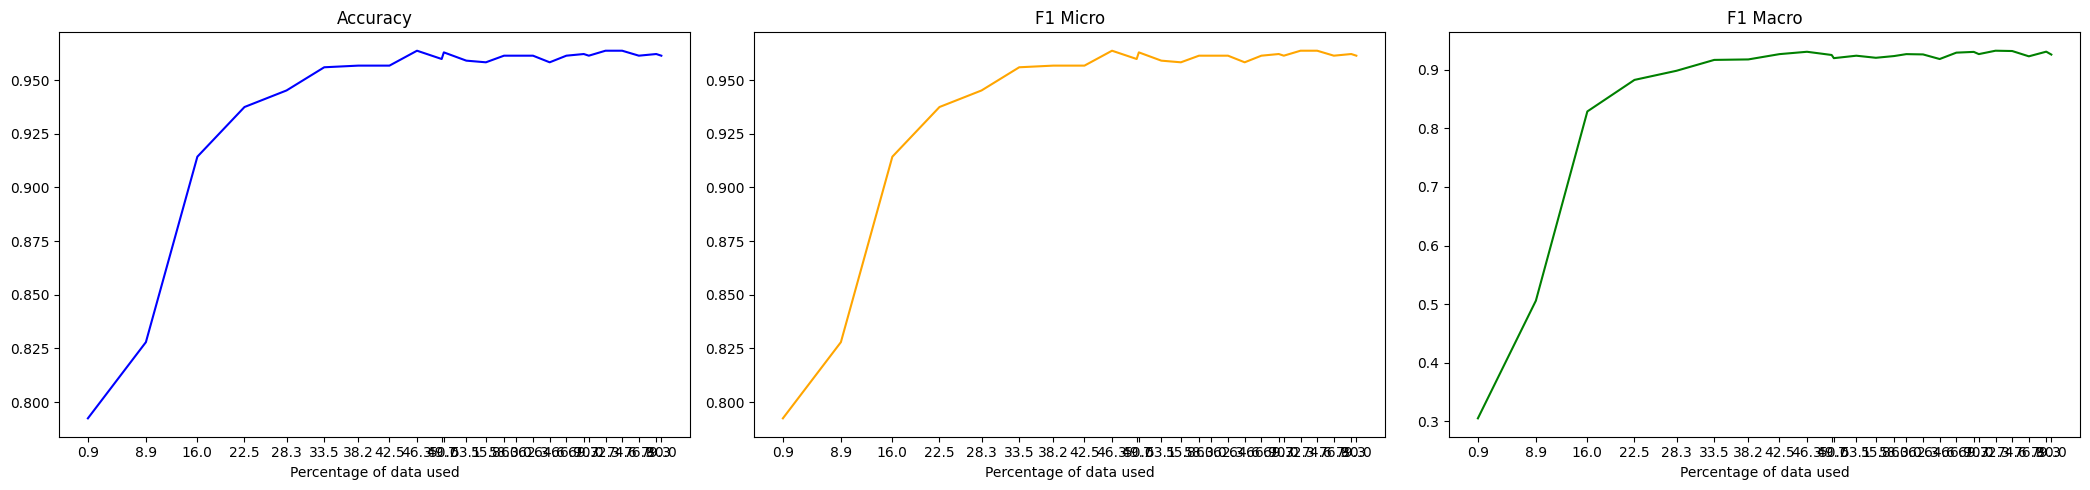

In [21]:
initial_train_size = int(0.01 * total_data)
active_learning(81, 0, 1)

Init Size: 10
Random seed: 81
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6328, Accuracy: 0.7493, F1 Micro: 0.85, F1 Macro: 0.8204
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5334, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4951, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4625, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 5/10, Train Loss: 0.4453, Accuracy: 0.7894, F1 Micro: 0.8822, F1 Macro: 0.8807
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4135, Accuracy: 0.7999, F1 Micro: 0.8872, F1 Macro: 0.8857
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3939, Accuracy: 0.8177, F1 Micro: 0.8959, F1 Macro: 0.8944
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3601, Accuracy: 0.846, F1 Micro: 0.91, F1 Macro: 0.9084
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3088, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.647, Accuracy: 0.743, F1 Micro: 0.743, F1 Macro: 0.4466
Epoch 2/10, Train Loss: 0.5679, Accuracy: 0.7374, F1 Micro: 0.7374, F1 Macro: 0.4244
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5035, Accuracy: 0.743, F1 Micro: 0.743, F1 Macro: 0.4466
Epoch 4/10, Train Loss: 0.4771, Accuracy: 0.7318, F1 Micro: 0.7318, F1 Macro: 0.5318
Epoch 5/10, Train Loss: 0.4109, Accuracy: 0.7263, F1 Micro: 0.7263, F1 Macro: 0.622
Epoch 6/10, Train Loss: 0.3137, Accuracy: 0.7263, F1 Micro: 0.7263, F1 Macro: 0.6489
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.267, Accuracy: 0.743, F1 Micro: 0.743, F1 Macro: 0.704
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1947, Accuracy: 0.7821, F1 Micro: 0.7821, F1 Macro: 0.7454
Epoch 9/10, Train Loss: 0.1264, Accuracy: 0.7765, F1 Micro: 0.7765, F1 Macro: 0.7258
Epoch 10/10, Train Loss: 0.0975, Accuracy: 0.7542, F1 Micro: 0.7542, F1 Macro: 0.7018

Sentiment analysis accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6172, Accuracy: 0.7932, F1 Micro: 0.8841, F1 Macro: 0.8825
Epoch 2/10, Train Loss: 0.5106, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 3/10, Train Loss: 0.5056, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 4/10, Train Loss: 0.4624, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4395, Accuracy: 0.817, F1 Micro: 0.8951, F1 Macro: 0.8936
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3838, Accuracy: 0.8624, F1 Micro: 0.9188, F1 Macro: 0.9172
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3396, Accuracy: 0.9048, F1 Micro: 0.9417, F1 Macro: 0.9392
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2891, Accuracy: 0.9174, F1 Micro: 0.9491, F1 Macro: 0.9466
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2438, Accuracy: 0.9234, F1 Micro: 0.9524, F1 Macro: 0.9495
Higher F1 achieved, sa

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5889, Accuracy: 0.6926, F1 Micro: 0.6926, F1 Macro: 0.4092
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.479, Accuracy: 0.6926, F1 Micro: 0.6926, F1 Macro: 0.4092
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4209, Accuracy: 0.6926, F1 Micro: 0.6926, F1 Macro: 0.4092
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3516, Accuracy: 0.8788, F1 Micro: 0.8788, F1 Macro: 0.8541
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2967, Accuracy: 0.8918, F1 Micro: 0.8918, F1 Macro: 0.8801
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.209, Accuracy: 0.9221, F1 Micro: 0.9221, F1 Macro: 0.9078
Epoch 7/10, Train Loss: 0.1809, Accuracy: 0.8961, F1 Micro: 0.8961, F1 Macro: 0.8807
Epoch 8/10, Train Loss: 0.0906, Accuracy: 0.9004, F1 Micro: 0.9004, F1 Macro: 0.8835
Epoch 9/10, Train Loss: 0.1817, Accuracy: 0.9004, F1 Micro: 0.9004, F1 Macro: 0.8861
Epoch 10/10, Train Loss: 0.1072, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5913, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4962, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4946, Accuracy: 0.7924, F1 Micro: 0.8837, F1 Macro: 0.8822
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4463, Accuracy: 0.8177, F1 Micro: 0.8961, F1 Macro: 0.8948
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3704, Accuracy: 0.8943, F1 Micro: 0.9358, F1 Macro: 0.9337
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3285, Accuracy: 0.9085, F1 Micro: 0.9434, F1 Macro: 0.9397
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2624, Accuracy: 0.9286, F1 Micro: 0.9558, F1 Macro: 0.9533
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2172, Accuracy: 0.9301, F1 Micro: 0.9566, F1 Macro: 0.9535
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6036, Accuracy: 0.7045, F1 Micro: 0.7045, F1 Macro: 0.4133
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4769, Accuracy: 0.7611, F1 Micro: 0.7611, F1 Macro: 0.6092
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2938, Accuracy: 0.8704, F1 Micro: 0.8704, F1 Macro: 0.8444
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1974, Accuracy: 0.8907, F1 Micro: 0.8907, F1 Macro: 0.8779
Epoch 5/10, Train Loss: 0.1211, Accuracy: 0.8785, F1 Micro: 0.8785, F1 Macro: 0.8542
Epoch 6/10, Train Loss: 0.1338, Accuracy: 0.8826, F1 Micro: 0.8826, F1 Macro: 0.868
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0917, Accuracy: 0.8907, F1 Micro: 0.8907, F1 Macro: 0.8722
Epoch 8/10, Train Loss: 0.0717, Accuracy: 0.8866, F1 Micro: 0.8866, F1 Macro: 0.8714
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0656, Accuracy: 0.8947, F1 Micro: 0.8947, F1 Macro: 0.8773
Epoch 10/10, Train Loss: 0.054, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5754, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.501, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4672, Accuracy: 0.8006, F1 Micro: 0.8879, F1 Macro: 0.8864
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3901, Accuracy: 0.8921, F1 Micro: 0.9354, F1 Macro: 0.9337
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3147, Accuracy: 0.9263, F1 Micro: 0.9545, F1 Macro: 0.9523
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2552, Accuracy: 0.933, F1 Micro: 0.9585, F1 Macro: 0.9558
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2079, Accuracy: 0.9501, F1 Micro: 0.9689, F1 Macro: 0.9674
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1824, Accuracy: 0.9516, F1 Micro: 0.9699, F1 Macro: 0.9686
Epoch 9/10, Train Loss: 0.1489, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5868, Accuracy: 0.6867, F1 Micro: 0.6867, F1 Macro: 0.4071
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4568, Accuracy: 0.8594, F1 Micro: 0.8594, F1 Macro: 0.8297
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2638, Accuracy: 0.8635, F1 Micro: 0.8635, F1 Macro: 0.849
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2054, Accuracy: 0.9116, F1 Micro: 0.9116, F1 Macro: 0.898
Epoch 5/10, Train Loss: 0.1543, Accuracy: 0.8996, F1 Micro: 0.8996, F1 Macro: 0.8853
Epoch 6/10, Train Loss: 0.1351, Accuracy: 0.8956, F1 Micro: 0.8956, F1 Macro: 0.874
Epoch 7/10, Train Loss: 0.1187, Accuracy: 0.8635, F1 Micro: 0.8635, F1 Macro: 0.8541
Epoch 8/10, Train Loss: 0.1093, Accuracy: 0.9076, F1 Micro: 0.9076, F1 Macro: 0.8907
Epoch 9/10, Train Loss: 0.1128, Accuracy: 0.8996, F1 Micro: 0.8996, F1 Macro: 0.8829
Epoch 10/10, Train Loss: 0.106, Accuracy: 0.8996, F1 Micro: 0.8996, F1 Macro: 0.8829

Sentiment analysis a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5641, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4846, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4341, Accuracy: 0.8542, F1 Micro: 0.915, F1 Macro: 0.9136
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.337, Accuracy: 0.9077, F1 Micro: 0.9428, F1 Macro: 0.9397
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.265, Accuracy: 0.9308, F1 Micro: 0.9571, F1 Macro: 0.9547
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2219, Accuracy: 0.9494, F1 Micro: 0.9686, F1 Macro: 0.9673
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1748, Accuracy: 0.9516, F1 Micro: 0.9699, F1 Macro: 0.9683
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.135, Accuracy: 0.9546, F1 Micro: 0.9717, F1 Macro: 0.9702
Epoch 9/10, Train Loss: 0.1149, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5577, Accuracy: 0.6736, F1 Micro: 0.6736, F1 Macro: 0.4025
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4518, Accuracy: 0.8719, F1 Micro: 0.8719, F1 Macro: 0.8519
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2377, Accuracy: 0.9298, F1 Micro: 0.9298, F1 Macro: 0.9204
Epoch 4/10, Train Loss: 0.1491, Accuracy: 0.9091, F1 Micro: 0.9091, F1 Macro: 0.8986
Epoch 5/10, Train Loss: 0.1425, Accuracy: 0.9132, F1 Micro: 0.9132, F1 Macro: 0.906
Epoch 6/10, Train Loss: 0.1344, Accuracy: 0.905, F1 Micro: 0.905, F1 Macro: 0.8954
Epoch 7/10, Train Loss: 0.1125, Accuracy: 0.9215, F1 Micro: 0.9215, F1 Macro: 0.9131
Epoch 8/10, Train Loss: 0.0692, Accuracy: 0.9091, F1 Micro: 0.9091, F1 Macro: 0.8952
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0753, Accuracy: 0.9298, F1 Micro: 0.9298, F1 Macro: 0.9223
Epoch 10/10, Train Loss: 0.1043, Accuracy: 0.9256, F1 Micro: 0.9256, F1 Macro: 0.9179

Sentiment analysis 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.548, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4706, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3994, Accuracy: 0.8929, F1 Micro: 0.9351, F1 Macro: 0.9333
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3165, Accuracy: 0.9375, F1 Micro: 0.9613, F1 Macro: 0.9598
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2323, Accuracy: 0.9405, F1 Micro: 0.963, F1 Macro: 0.9605
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1885, Accuracy: 0.9516, F1 Micro: 0.9699, F1 Macro: 0.968
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1435, Accuracy: 0.9524, F1 Micro: 0.9703, F1 Macro: 0.9687
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1227, Accuracy: 0.9606, F1 Micro: 0.9754, F1 Macro: 0.974
Epoch 9/10, Train Loss: 0.1031, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5931, Accuracy: 0.6789, F1 Micro: 0.6789, F1 Macro: 0.4044
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3159, Accuracy: 0.8943, F1 Micro: 0.8943, F1 Macro: 0.8818
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1906, Accuracy: 0.9309, F1 Micro: 0.9309, F1 Macro: 0.9215
Epoch 4/10, Train Loss: 0.1215, Accuracy: 0.9268, F1 Micro: 0.9268, F1 Macro: 0.9187
Epoch 5/10, Train Loss: 0.1144, Accuracy: 0.9268, F1 Micro: 0.9268, F1 Macro: 0.9191
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0884, Accuracy: 0.935, F1 Micro: 0.935, F1 Macro: 0.9254
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0955, Accuracy: 0.9553, F1 Micro: 0.9553, F1 Macro: 0.9498
Epoch 8/10, Train Loss: 0.0673, Accuracy: 0.939, F1 Micro: 0.939, F1 Macro: 0.9294
Epoch 9/10, Train Loss: 0.07, Accuracy: 0.9431, F1 Micro: 0.9431, F1 Macro: 0.9356
Epoch 10/10, Train Loss: 0.0682, Accuracy: 0.939, F1 Micro: 0.939, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5549, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4707, Accuracy: 0.7991, F1 Micro: 0.8871, F1 Macro: 0.8857
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3736, Accuracy: 0.907, F1 Micro: 0.9425, F1 Macro: 0.9404
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.286, Accuracy: 0.9457, F1 Micro: 0.9665, F1 Macro: 0.9651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2114, Accuracy: 0.9524, F1 Micro: 0.9704, F1 Macro: 0.969
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1657, Accuracy: 0.9568, F1 Micro: 0.973, F1 Macro: 0.9716
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1263, Accuracy: 0.9583, F1 Micro: 0.974, F1 Macro: 0.9728
Epoch 8/10, Train Loss: 0.1094, Accuracy: 0.9583, F1 Micro: 0.9739, F1 Macro: 0.9725
Epoch 9/10, Train Loss: 0.0929, Accuracy: 0.9568, F1 Micro: 0.973, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5451, Accuracy: 0.7308, F1 Micro: 0.7308, F1 Macro: 0.5731
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3552, Accuracy: 0.9077, F1 Micro: 0.9077, F1 Macro: 0.8957
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2144, Accuracy: 0.9154, F1 Micro: 0.9154, F1 Macro: 0.906
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1686, Accuracy: 0.9346, F1 Micro: 0.9346, F1 Macro: 0.9264
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1139, Accuracy: 0.9385, F1 Micro: 0.9385, F1 Macro: 0.9309
Epoch 6/10, Train Loss: 0.0962, Accuracy: 0.9269, F1 Micro: 0.9269, F1 Macro: 0.9157
Epoch 7/10, Train Loss: 0.1005, Accuracy: 0.9308, F1 Micro: 0.9308, F1 Macro: 0.9235
Epoch 8/10, Train Loss: 0.0959, Accuracy: 0.9308, F1 Micro: 0.9308, F1 Macro: 0.9235
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0862, Accuracy: 0.9423, F1 Micro: 0.9423, F1 Macro: 0.9354
Epoch 10/10, Train Loss: 0.0508, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5547, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4638, Accuracy: 0.8162, F1 Micro: 0.8956, F1 Macro: 0.8941
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3595, Accuracy: 0.9204, F1 Micro: 0.9504, F1 Macro: 0.9482
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2662, Accuracy: 0.9449, F1 Micro: 0.966, F1 Macro: 0.9646
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2037, Accuracy: 0.9464, F1 Micro: 0.9666, F1 Macro: 0.9648
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1573, Accuracy: 0.9554, F1 Micro: 0.9721, F1 Macro: 0.9707
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1249, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9756
Epoch 8/10, Train Loss: 0.1063, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9746
Epoch 9/10, Train Loss: 0.0822, Accuracy: 0.9583, F1 Micro: 0.9738, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5508, Accuracy: 0.6882, F1 Micro: 0.6882, F1 Macro: 0.4077
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3065, Accuracy: 0.9049, F1 Micro: 0.9049, F1 Macro: 0.8958
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2087, Accuracy: 0.9202, F1 Micro: 0.9202, F1 Macro: 0.9116
Epoch 4/10, Train Loss: 0.1536, Accuracy: 0.9087, F1 Micro: 0.9087, F1 Macro: 0.8997
Epoch 5/10, Train Loss: 0.1215, Accuracy: 0.9125, F1 Micro: 0.9125, F1 Macro: 0.9036
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0978, Accuracy: 0.9354, F1 Micro: 0.9354, F1 Macro: 0.9244
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0659, Accuracy: 0.9392, F1 Micro: 0.9392, F1 Macro: 0.9309
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0812, Accuracy: 0.943, F1 Micro: 0.943, F1 Macro: 0.9333
Epoch 9/10, Train Loss: 0.0683, Accuracy: 0.9392, F1 Micro: 0.9392, F1 Macro: 0.9296
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5286, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4646, Accuracy: 0.8311, F1 Micro: 0.9031, F1 Macro: 0.9018
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3483, Accuracy: 0.9323, F1 Micro: 0.9583, F1 Macro: 0.9568
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2657, Accuracy: 0.9501, F1 Micro: 0.9693, F1 Macro: 0.9679
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.187, Accuracy: 0.9554, F1 Micro: 0.9722, F1 Macro: 0.9714
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1471, Accuracy: 0.9591, F1 Micro: 0.9743, F1 Macro: 0.9729
Epoch 7/10, Train Loss: 0.114, Accuracy: 0.9568, F1 Micro: 0.973, F1 Macro: 0.9718
Epoch 8/10, Train Loss: 0.0888, Accuracy: 0.9576, F1 Micro: 0.9733, F1 Macro: 0.9717
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0786, Accuracy: 0.9598, F1 Micro: 0.9748, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5521, Accuracy: 0.8438, F1 Micro: 0.8438, F1 Macro: 0.7959
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2836, Accuracy: 0.918, F1 Micro: 0.918, F1 Macro: 0.9028
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1842, Accuracy: 0.9219, F1 Micro: 0.9219, F1 Macro: 0.9091
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1234, Accuracy: 0.9375, F1 Micro: 0.9375, F1 Macro: 0.9282
Epoch 5/10, Train Loss: 0.1344, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.923
Epoch 6/10, Train Loss: 0.0841, Accuracy: 0.9219, F1 Micro: 0.9219, F1 Macro: 0.9129
Epoch 7/10, Train Loss: 0.0598, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.924
Epoch 8/10, Train Loss: 0.0863, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.923
Epoch 9/10, Train Loss: 0.0551, Accuracy: 0.9297, F1 Micro: 0.9297, F1 Macro: 0.9182
Epoch 10/10, Train Loss: 0.0546, Accuracy: 0.9258, F1 Micro: 0.9258, F1 Macro: 0.9127

Sentiment analysis ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5386, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4479, Accuracy: 0.84, F1 Micro: 0.9078, F1 Macro: 0.9066
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3298, Accuracy: 0.939, F1 Micro: 0.9625, F1 Macro: 0.961
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2379, Accuracy: 0.9457, F1 Micro: 0.9662, F1 Macro: 0.9651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.181, Accuracy: 0.9554, F1 Micro: 0.9722, F1 Macro: 0.9711
Epoch 6/10, Train Loss: 0.1403, Accuracy: 0.9539, F1 Micro: 0.9711, F1 Macro: 0.9698
Epoch 7/10, Train Loss: 0.1071, Accuracy: 0.9524, F1 Micro: 0.97, F1 Macro: 0.9683
Epoch 8/10, Train Loss: 0.0862, Accuracy: 0.9539, F1 Micro: 0.9709, F1 Macro: 0.9691
Epoch 9/10, Train Loss: 0.0699, Accuracy: 0.9531, F1 Micro: 0.9704, F1 Macro: 0.9682
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5569, Accuracy: 0.6992, F1 Micro: 0.6992, F1 Macro: 0.4115
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3258, Accuracy: 0.9211, F1 Micro: 0.9211, F1 Macro: 0.9089
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1518, Accuracy: 0.9211, F1 Micro: 0.9211, F1 Macro: 0.9089
Epoch 4/10, Train Loss: 0.1438, Accuracy: 0.9023, F1 Micro: 0.9023, F1 Macro: 0.8914
Epoch 5/10, Train Loss: 0.129, Accuracy: 0.9135, F1 Micro: 0.9135, F1 Macro: 0.9032
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1194, Accuracy: 0.9286, F1 Micro: 0.9286, F1 Macro: 0.9181
Epoch 7/10, Train Loss: 0.0986, Accuracy: 0.9173, F1 Micro: 0.9173, F1 Macro: 0.9024
Epoch 8/10, Train Loss: 0.0785, Accuracy: 0.9211, F1 Micro: 0.9211, F1 Macro: 0.9111
Epoch 9/10, Train Loss: 0.069, Accuracy: 0.906, F1 Micro: 0.906, F1 Macro: 0.8923
Epoch 10/10, Train Loss: 0.0669, Accuracy: 0.9173, F1 Micro: 0.9173, F1 Macro: 0.9049

Sentiment analysis a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5471, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4568, Accuracy: 0.8824, F1 Micro: 0.9301, F1 Macro: 0.9287
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3149, Accuracy: 0.9375, F1 Micro: 0.9611, F1 Macro: 0.959
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2322, Accuracy: 0.9509, F1 Micro: 0.9695, F1 Macro: 0.9681
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1736, Accuracy: 0.9539, F1 Micro: 0.9711, F1 Macro: 0.9694
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1329, Accuracy: 0.9561, F1 Micro: 0.9725, F1 Macro: 0.9709
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1033, Accuracy: 0.9568, F1 Micro: 0.9728, F1 Macro: 0.9711
Epoch 8/10, Train Loss: 0.0869, Accuracy: 0.9554, F1 Micro: 0.9718, F1 Macro: 0.9696
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0727, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5516, Accuracy: 0.8101, F1 Micro: 0.8101, F1 Macro: 0.7324
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2695, Accuracy: 0.9186, F1 Micro: 0.9186, F1 Macro: 0.9087
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1782, Accuracy: 0.9341, F1 Micro: 0.9341, F1 Macro: 0.9233
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1707, Accuracy: 0.938, F1 Micro: 0.938, F1 Macro: 0.9298
Epoch 5/10, Train Loss: 0.1183, Accuracy: 0.9186, F1 Micro: 0.9186, F1 Macro: 0.9097
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1379, Accuracy: 0.9419, F1 Micro: 0.9419, F1 Macro: 0.9344
Epoch 7/10, Train Loss: 0.0821, Accuracy: 0.9225, F1 Micro: 0.9225, F1 Macro: 0.9117
Epoch 8/10, Train Loss: 0.0697, Accuracy: 0.9302, F1 Micro: 0.9302, F1 Macro: 0.921
Epoch 9/10, Train Loss: 0.0683, Accuracy: 0.9302, F1 Micro: 0.9302, F1 Macro: 0.9201
Epoch 10/10, Train Loss: 0.0469, Accuracy: 0.9147, F1 Micro: 0.9147, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5412, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4316, Accuracy: 0.8943, F1 Micro: 0.9363, F1 Macro: 0.9349
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3059, Accuracy: 0.9449, F1 Micro: 0.966, F1 Macro: 0.9644
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2138, Accuracy: 0.9516, F1 Micro: 0.9697, F1 Macro: 0.9677
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1686, Accuracy: 0.9583, F1 Micro: 0.9739, F1 Macro: 0.9727
Epoch 6/10, Train Loss: 0.1302, Accuracy: 0.9554, F1 Micro: 0.9719, F1 Macro: 0.9696
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1054, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9747
Epoch 8/10, Train Loss: 0.0824, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9744
Epoch 9/10, Train Loss: 0.0684, Accuracy: 0.9613, F1 Micro: 0.9755, F1 Macro: 0.9735
Higher F1 achieved, s

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5402, Accuracy: 0.7701, F1 Micro: 0.7701, F1 Macro: 0.6633
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.28, Accuracy: 0.9349, F1 Micro: 0.9349, F1 Macro: 0.9281
Epoch 3/10, Train Loss: 0.1821, Accuracy: 0.9272, F1 Micro: 0.9272, F1 Macro: 0.9205
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1704, Accuracy: 0.9387, F1 Micro: 0.9387, F1 Macro: 0.9325
Epoch 5/10, Train Loss: 0.1305, Accuracy: 0.931, F1 Micro: 0.931, F1 Macro: 0.9215
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1274, Accuracy: 0.9425, F1 Micro: 0.9425, F1 Macro: 0.9355
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0837, Accuracy: 0.9425, F1 Micro: 0.9425, F1 Macro: 0.9366
Epoch 8/10, Train Loss: 0.1028, Accuracy: 0.9195, F1 Micro: 0.9195, F1 Macro: 0.9125
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0777, Accuracy: 0.9464, F1 Micro: 0.9464, F1 Macro: 0.9403
Epoch 10/10, Train Loss: 0.0763, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5331, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4277, Accuracy: 0.9055, F1 Micro: 0.9426, F1 Macro: 0.9409
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2921, Accuracy: 0.933, F1 Micro: 0.9584, F1 Macro: 0.9551
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2146, Accuracy: 0.9501, F1 Micro: 0.9689, F1 Macro: 0.9673
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1571, Accuracy: 0.9554, F1 Micro: 0.972, F1 Macro: 0.9702
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1165, Accuracy: 0.9583, F1 Micro: 0.9737, F1 Macro: 0.9714
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0959, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9743
Epoch 8/10, Train Loss: 0.0768, Accuracy: 0.9591, F1 Micro: 0.9744, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0643, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5285, Accuracy: 0.8702, F1 Micro: 0.8702, F1 Macro: 0.846
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2475, Accuracy: 0.8931, F1 Micro: 0.8931, F1 Macro: 0.8844
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.203, Accuracy: 0.9313, F1 Micro: 0.9313, F1 Macro: 0.9242
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1289, Accuracy: 0.9389, F1 Micro: 0.9389, F1 Macro: 0.9316
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1216, Accuracy: 0.9427, F1 Micro: 0.9427, F1 Macro: 0.9357
Epoch 6/10, Train Loss: 0.0891, Accuracy: 0.9351, F1 Micro: 0.9351, F1 Macro: 0.9283
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1032, Accuracy: 0.9466, F1 Micro: 0.9466, F1 Macro: 0.939
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0952, Accuracy: 0.9504, F1 Micro: 0.9504, F1 Macro: 0.9432
Epoch 9/10, Train Loss: 0.0789, Accuracy: 0.9313, F1 Micro: 0.9313, F1 Macro: 0.9234
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5358, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4266, Accuracy: 0.8988, F1 Micro: 0.9388, F1 Macro: 0.9374
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2867, Accuracy: 0.9531, F1 Micro: 0.971, F1 Macro: 0.9697
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2073, Accuracy: 0.9568, F1 Micro: 0.9731, F1 Macro: 0.9716
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1514, Accuracy: 0.9613, F1 Micro: 0.9759, F1 Macro: 0.9749
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1183, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0872, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9752
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0724, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9766
Epoch 9/10, Train Loss: 0.0583, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.532, Accuracy: 0.8659, F1 Micro: 0.8659, F1 Macro: 0.8428
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2933, Accuracy: 0.9387, F1 Micro: 0.9387, F1 Macro: 0.9314
Epoch 3/10, Train Loss: 0.1992, Accuracy: 0.9272, F1 Micro: 0.9272, F1 Macro: 0.9174
Epoch 4/10, Train Loss: 0.1543, Accuracy: 0.9272, F1 Micro: 0.9272, F1 Macro: 0.9205
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1245, Accuracy: 0.9425, F1 Micro: 0.9425, F1 Macro: 0.9362
Epoch 6/10, Train Loss: 0.1188, Accuracy: 0.931, F1 Micro: 0.931, F1 Macro: 0.9241
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1049, Accuracy: 0.9502, F1 Micro: 0.9502, F1 Macro: 0.9441
Epoch 8/10, Train Loss: 0.0817, Accuracy: 0.9349, F1 Micro: 0.9349, F1 Macro: 0.9265
Epoch 9/10, Train Loss: 0.0575, Accuracy: 0.9425, F1 Micro: 0.9425, F1 Macro: 0.9359
Epoch 10/10, Train Loss: 0.0703, Accuracy: 0.9387, F1 Micro: 0.9387, F1 Macro: 0.9318

Sentiment analysis 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5347, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4217, Accuracy: 0.9062, F1 Micro: 0.9417, F1 Macro: 0.9392
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2878, Accuracy: 0.9464, F1 Micro: 0.9668, F1 Macro: 0.9649
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1954, Accuracy: 0.9568, F1 Micro: 0.9731, F1 Macro: 0.972
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1475, Accuracy: 0.9598, F1 Micro: 0.9747, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1079, Accuracy: 0.9673, F1 Micro: 0.9795, F1 Macro: 0.9785
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0904, Accuracy: 0.9673, F1 Micro: 0.9795, F1 Macro: 0.9784
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0732, Accuracy: 0.968, F1 Micro: 0.9798, F1 Macro: 0.9783
Epoch 9/10, Train Loss: 0.0628, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5537, Accuracy: 0.8633, F1 Micro: 0.8633, F1 Macro: 0.8343
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2301, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.9258
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1487, Accuracy: 0.9414, F1 Micro: 0.9414, F1 Macro: 0.9349
Epoch 4/10, Train Loss: 0.1718, Accuracy: 0.9375, F1 Micro: 0.9375, F1 Macro: 0.9315
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1428, Accuracy: 0.9609, F1 Micro: 0.9609, F1 Macro: 0.9565
Epoch 6/10, Train Loss: 0.1219, Accuracy: 0.9531, F1 Micro: 0.9531, F1 Macro: 0.9481
Epoch 7/10, Train Loss: 0.1277, Accuracy: 0.957, F1 Micro: 0.957, F1 Macro: 0.952
Epoch 8/10, Train Loss: 0.0908, Accuracy: 0.9453, F1 Micro: 0.9453, F1 Macro: 0.9394
Epoch 9/10, Train Loss: 0.0778, Accuracy: 0.9414, F1 Micro: 0.9414, F1 Macro: 0.9356
Epoch 10/10, Train Loss: 0.0447, Accuracy: 0.9492, F1 Micro: 0.9492, F1 Macro: 0.9419

Sentiment analysis 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5317, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4174, Accuracy: 0.9196, F1 Micro: 0.9507, F1 Macro: 0.9491
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2762, Accuracy: 0.9509, F1 Micro: 0.9696, F1 Macro: 0.9684
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1879, Accuracy: 0.9568, F1 Micro: 0.973, F1 Macro: 0.9716
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1437, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.9771
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1061, Accuracy: 0.9673, F1 Micro: 0.9795, F1 Macro: 0.9782
Epoch 7/10, Train Loss: 0.0835, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Macro: 0.9756
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0702, Accuracy: 0.9695, F1 Micro: 0.9809, F1 Macro: 0.9798
Epoch 9/10, Train Loss: 0.0619, Accuracy: 0.968, F1 Micro: 0.9798, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5185, Accuracy: 0.8889, F1 Micro: 0.8889, F1 Macro: 0.8715
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2636, Accuracy: 0.9387, F1 Micro: 0.9387, F1 Macro: 0.9306
Epoch 3/10, Train Loss: 0.1721, Accuracy: 0.931, F1 Micro: 0.931, F1 Macro: 0.92
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1205, Accuracy: 0.9502, F1 Micro: 0.9502, F1 Macro: 0.9441
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1548, Accuracy: 0.9502, F1 Micro: 0.9502, F1 Macro: 0.9441
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1114, Accuracy: 0.9502, F1 Micro: 0.9502, F1 Macro: 0.9441
Epoch 7/10, Train Loss: 0.0758, Accuracy: 0.9425, F1 Micro: 0.9425, F1 Macro: 0.9369
Epoch 8/10, Train Loss: 0.0776, Accuracy: 0.9387, F1 Micro: 0.9387, F1 Macro: 0.9318
Epoch 9/10, Train Loss: 0.0707, Accuracy: 0.9349, F1 Micro: 0.9349, F1 Macro: 0.9285
Epoch 10/10, Train Loss: 0.0692, Accuracy: 0.9234, F1 Micro: 0.9234, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5277, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3937, Accuracy: 0.9241, F1 Micro: 0.9532, F1 Macro: 0.9513
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2738, Accuracy: 0.9531, F1 Micro: 0.9709, F1 Macro: 0.9699
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1852, Accuracy: 0.9598, F1 Micro: 0.9749, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.138, Accuracy: 0.9628, F1 Micro: 0.9768, F1 Macro: 0.9758
Epoch 6/10, Train Loss: 0.1099, Accuracy: 0.9606, F1 Micro: 0.9751, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0828, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9767
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0671, Accuracy: 0.968, F1 Micro: 0.9798, F1 Macro: 0.9784
Epoch 9/10, Train Loss: 0.0609, Accuracy: 0.9658, F1 Micro: 0.9783, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4727, Accuracy: 0.8854, F1 Micro: 0.8854, F1 Macro: 0.8765
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2554, Accuracy: 0.9447, F1 Micro: 0.9447, F1 Macro: 0.939
Epoch 3/10, Train Loss: 0.1825, Accuracy: 0.9407, F1 Micro: 0.9407, F1 Macro: 0.9355
Epoch 4/10, Train Loss: 0.1431, Accuracy: 0.9368, F1 Micro: 0.9368, F1 Macro: 0.9303
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1304, Accuracy: 0.9447, F1 Micro: 0.9447, F1 Macro: 0.9372
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.093, Accuracy: 0.9526, F1 Micro: 0.9526, F1 Macro: 0.9477
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0847, Accuracy: 0.9684, F1 Micro: 0.9684, F1 Macro: 0.9648
Epoch 8/10, Train Loss: 0.0759, Accuracy: 0.9328, F1 Micro: 0.9328, F1 Macro: 0.9269
Epoch 9/10, Train Loss: 0.0691, Accuracy: 0.9407, F1 Micro: 0.9407, F1 Macro: 0.9355
Epoch 10/10, Train Loss: 0.0435, Accuracy: 0.9447, F1 Micro: 0.9447, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5282, Accuracy: 0.7969, F1 Micro: 0.886, F1 Macro: 0.8846
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4049, Accuracy: 0.9241, F1 Micro: 0.9533, F1 Macro: 0.9515
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2647, Accuracy: 0.9524, F1 Micro: 0.9704, F1 Macro: 0.9688
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1852, Accuracy: 0.9613, F1 Micro: 0.9759, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1422, Accuracy: 0.9621, F1 Micro: 0.9763, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.106, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.977
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0808, Accuracy: 0.9702, F1 Micro: 0.9813, F1 Macro: 0.9802
Epoch 8/10, Train Loss: 0.0662, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Macro: 0.9756
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0537, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.517, Accuracy: 0.8833, F1 Micro: 0.8833, F1 Macro: 0.8697
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2617, Accuracy: 0.93, F1 Micro: 0.93, F1 Macro: 0.9238
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2141, Accuracy: 0.93, F1 Micro: 0.93, F1 Macro: 0.9231
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1306, Accuracy: 0.9416, F1 Micro: 0.9416, F1 Macro: 0.936
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1397, Accuracy: 0.9533, F1 Micro: 0.9533, F1 Macro: 0.9476
Epoch 6/10, Train Loss: 0.132, Accuracy: 0.9339, F1 Micro: 0.9339, F1 Macro: 0.9279
Epoch 7/10, Train Loss: 0.0732, Accuracy: 0.9416, F1 Micro: 0.9416, F1 Macro: 0.936
Epoch 8/10, Train Loss: 0.0617, Accuracy: 0.9416, F1 Micro: 0.9416, F1 Macro: 0.936
Epoch 9/10, Train Loss: 0.0534, Accuracy: 0.9377, F1 Micro: 0.9377, F1 Macro: 0.9312
Epoch 10/10, Train Loss: 0.0262, Accuracy: 0.9455, F1 Micro: 0.9455, F1 Macro: 0.93

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5277, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3969, Accuracy: 0.9249, F1 Micro: 0.9533, F1 Macro: 0.9514
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2597, Accuracy: 0.9546, F1 Micro: 0.9717, F1 Macro: 0.9706
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1771, Accuracy: 0.9606, F1 Micro: 0.9755, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1275, Accuracy: 0.9635, F1 Micro: 0.9772, F1 Macro: 0.9761
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0988, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9777
Epoch 7/10, Train Loss: 0.0794, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9761
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0624, Accuracy: 0.9702, F1 Micro: 0.9812, F1 Macro: 0.9801
Epoch 9/10, Train Loss: 0.0536, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5587, Accuracy: 0.883, F1 Micro: 0.883, F1 Macro: 0.8685
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2654, Accuracy: 0.8981, F1 Micro: 0.8981, F1 Macro: 0.8895
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1948, Accuracy: 0.9208, F1 Micro: 0.9208, F1 Macro: 0.9137
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1578, Accuracy: 0.9321, F1 Micro: 0.9321, F1 Macro: 0.9247
Epoch 5/10, Train Loss: 0.1462, Accuracy: 0.9283, F1 Micro: 0.9283, F1 Macro: 0.9207
Epoch 6/10, Train Loss: 0.1144, Accuracy: 0.9283, F1 Micro: 0.9283, F1 Macro: 0.9169
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0989, Accuracy: 0.9434, F1 Micro: 0.9434, F1 Macro: 0.9371
Epoch 8/10, Train Loss: 0.095, Accuracy: 0.9283, F1 Micro: 0.9283, F1 Macro: 0.9211
Epoch 9/10, Train Loss: 0.0802, Accuracy: 0.9321, F1 Micro: 0.9321, F1 Macro: 0.923
Epoch 10/10, Train Loss: 0.0456, Accuracy: 0.9396, F1 Micro: 0.9396, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5158, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3621, Accuracy: 0.9115, F1 Micro: 0.9442, F1 Macro: 0.9412
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2419, Accuracy: 0.9554, F1 Micro: 0.9722, F1 Macro: 0.9708
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1717, Accuracy: 0.9658, F1 Micro: 0.9786, F1 Macro: 0.9775
Epoch 5/10, Train Loss: 0.1173, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.975
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0952, Accuracy: 0.9695, F1 Micro: 0.9808, F1 Macro: 0.9797
Epoch 7/10, Train Loss: 0.0757, Accuracy: 0.9688, F1 Micro: 0.9802, F1 Macro: 0.9787
Epoch 8/10, Train Loss: 0.0589, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9777
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0522, Accuracy: 0.9717, F1 Micro: 0.9822, F1 Macro: 0.9811
Epoch 10/10, Train Lo

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4995, Accuracy: 0.9202, F1 Micro: 0.9202, F1 Macro: 0.909
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2665, Accuracy: 0.9316, F1 Micro: 0.9316, F1 Macro: 0.9255
Epoch 3/10, Train Loss: 0.1792, Accuracy: 0.9278, F1 Micro: 0.9278, F1 Macro: 0.9182
Epoch 4/10, Train Loss: 0.1602, Accuracy: 0.924, F1 Micro: 0.924, F1 Macro: 0.9172
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1033, Accuracy: 0.9544, F1 Micro: 0.9544, F1 Macro: 0.9488
Epoch 6/10, Train Loss: 0.1026, Accuracy: 0.9202, F1 Micro: 0.9202, F1 Macro: 0.9133
Epoch 7/10, Train Loss: 0.0709, Accuracy: 0.9392, F1 Micro: 0.9392, F1 Macro: 0.9328
Epoch 8/10, Train Loss: 0.0596, Accuracy: 0.924, F1 Micro: 0.924, F1 Macro: 0.9164
Epoch 9/10, Train Loss: 0.0798, Accuracy: 0.9087, F1 Micro: 0.9087, F1 Macro: 0.9016
Epoch 10/10, Train Loss: 0.0434, Accuracy: 0.924, F1 Micro: 0.924, F1 Macro: 0.9146

Sentiment analysis accuracy: 0.9544, F1 Micro: 0.9544, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5322, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3926, Accuracy: 0.9234, F1 Micro: 0.9521, F1 Macro: 0.9494
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2493, Accuracy: 0.9576, F1 Micro: 0.9737, F1 Macro: 0.9725
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1708, Accuracy: 0.9643, F1 Micro: 0.9777, F1 Macro: 0.9768
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1315, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9779
Epoch 6/10, Train Loss: 0.0957, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9772
Epoch 7/10, Train Loss: 0.0776, Accuracy: 0.9665, F1 Micro: 0.9788, F1 Macro: 0.9772
Epoch 8/10, Train Loss: 0.06, Accuracy: 0.9673, F1 Micro: 0.9793, F1 Macro: 0.9777
Epoch 9/10, Train Loss: 0.0494, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9774
Higher F1 achieved, saving model
Epoch 10/10, Train Los

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5149, Accuracy: 0.8533, F1 Micro: 0.8533, F1 Macro: 0.8464
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2654, Accuracy: 0.9421, F1 Micro: 0.9421, F1 Macro: 0.9363
Epoch 3/10, Train Loss: 0.178, Accuracy: 0.9228, F1 Micro: 0.9228, F1 Macro: 0.9161
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1273, Accuracy: 0.9459, F1 Micro: 0.9459, F1 Macro: 0.9404
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0822, Accuracy: 0.9575, F1 Micro: 0.9575, F1 Macro: 0.9528
Epoch 6/10, Train Loss: 0.0985, Accuracy: 0.9421, F1 Micro: 0.9421, F1 Macro: 0.9356
Epoch 7/10, Train Loss: 0.0762, Accuracy: 0.9305, F1 Micro: 0.9305, F1 Macro: 0.9207
Epoch 8/10, Train Loss: 0.0508, Accuracy: 0.9459, F1 Micro: 0.9459, F1 Macro: 0.9391
Epoch 9/10, Train Loss: 0.048, Accuracy: 0.9266, F1 Micro: 0.9266, F1 Macro: 0.9189
Epoch 10/10, Train Loss: 0.0524, Accuracy: 0.9305, F1 Micro: 0.9305, F1 Macro: 0.9225

Sentiment analysis

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5208, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3624, Accuracy: 0.933, F1 Micro: 0.958, F1 Macro: 0.9563
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2235, Accuracy: 0.9568, F1 Micro: 0.9731, F1 Macro: 0.9715
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1685, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.9748
Epoch 5/10, Train Loss: 0.1177, Accuracy: 0.9621, F1 Micro: 0.9759, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0892, Accuracy: 0.9658, F1 Micro: 0.9783, F1 Macro: 0.9766
Epoch 7/10, Train Loss: 0.0709, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9762
Epoch 8/10, Train Loss: 0.059, Accuracy: 0.9635, F1 Micro: 0.9769, F1 Macro: 0.9752
Epoch 9/10, Train Loss: 0.0502, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.975
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4658, Accuracy: 0.9007, F1 Micro: 0.9007, F1 Macro: 0.8916
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2136, Accuracy: 0.9191, F1 Micro: 0.9191, F1 Macro: 0.9115
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1619, Accuracy: 0.9265, F1 Micro: 0.9265, F1 Macro: 0.9187
Epoch 4/10, Train Loss: 0.1093, Accuracy: 0.9154, F1 Micro: 0.9154, F1 Macro: 0.9063
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1283, Accuracy: 0.9338, F1 Micro: 0.9338, F1 Macro: 0.924
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0937, Accuracy: 0.9338, F1 Micro: 0.9338, F1 Macro: 0.9248
Epoch 7/10, Train Loss: 0.0694, Accuracy: 0.9044, F1 Micro: 0.9044, F1 Macro: 0.8949
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0715, Accuracy: 0.9412, F1 Micro: 0.9412, F1 Macro: 0.9332
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0829, Accuracy: 0.9412, F1 Micro: 0.9412, F1 Macro: 0.9332
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5144, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3704, Accuracy: 0.9256, F1 Micro: 0.9538, F1 Macro: 0.9515
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2384, Accuracy: 0.9546, F1 Micro: 0.9718, F1 Macro: 0.9704
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1665, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9734
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1244, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1016, Accuracy: 0.968, F1 Micro: 0.9798, F1 Macro: 0.9784
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0755, Accuracy: 0.9702, F1 Micro: 0.9813, F1 Macro: 0.9802
Epoch 8/10, Train Loss: 0.0634, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9766
Epoch 9/10, Train Loss: 0.0463, Accuracy: 0.9695, F1 Micro: 0.9808, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4862, Accuracy: 0.8842, F1 Micro: 0.8842, F1 Macro: 0.8742
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2261, Accuracy: 0.9228, F1 Micro: 0.9228, F1 Macro: 0.9161
Epoch 3/10, Train Loss: 0.1567, Accuracy: 0.9189, F1 Micro: 0.9189, F1 Macro: 0.9113
Epoch 4/10, Train Loss: 0.1546, Accuracy: 0.9112, F1 Micro: 0.9112, F1 Macro: 0.9038
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1353, Accuracy: 0.9266, F1 Micro: 0.9266, F1 Macro: 0.9193
Epoch 6/10, Train Loss: 0.1083, Accuracy: 0.9151, F1 Micro: 0.9151, F1 Macro: 0.9077
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0732, Accuracy: 0.9344, F1 Micro: 0.9344, F1 Macro: 0.9266
Epoch 8/10, Train Loss: 0.066, Accuracy: 0.9112, F1 Micro: 0.9112, F1 Macro: 0.8996
Epoch 9/10, Train Loss: 0.077, Accuracy: 0.9266, F1 Micro: 0.9266, F1 Macro: 0.9189
Epoch 10/10, Train Loss: 0.0615, Accuracy: 0.9189, F1 Micro: 0.9189, F1 Macro: 0.9108

Sentiment analysis

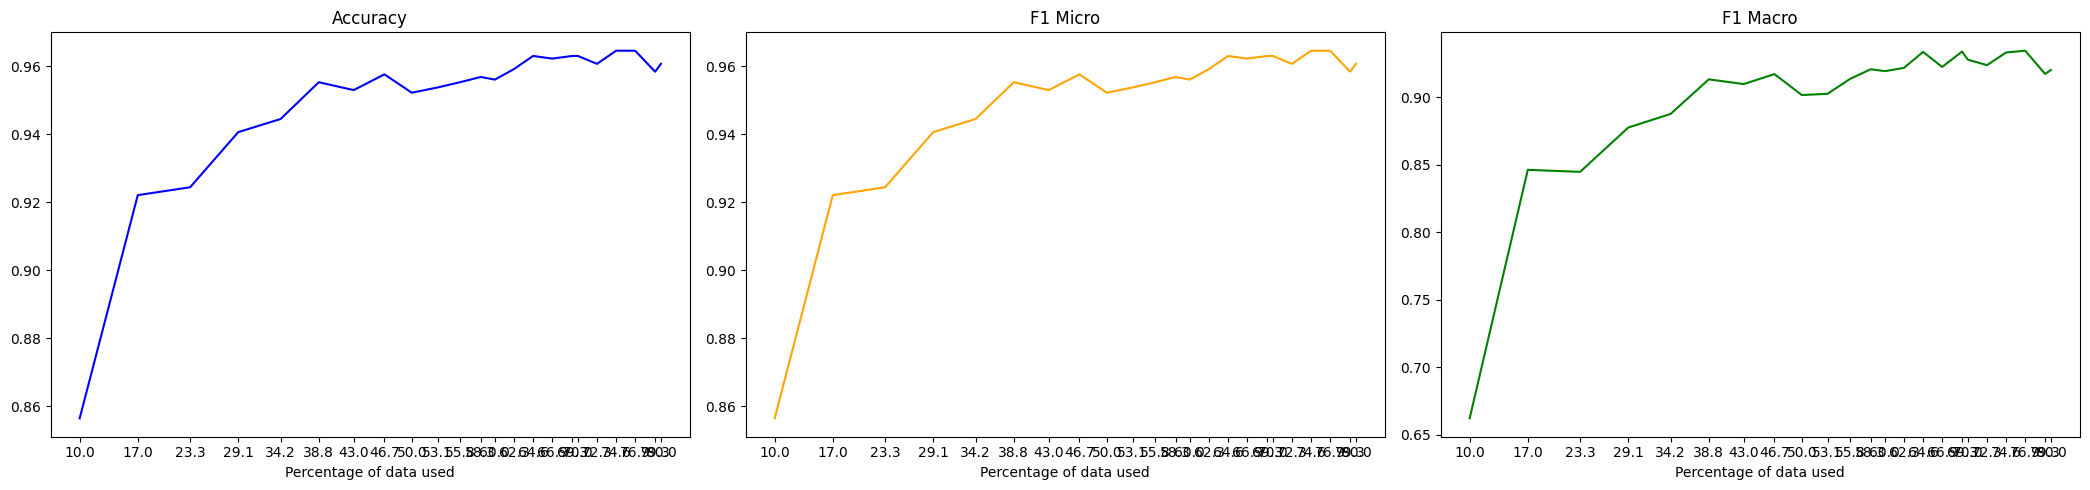

In [22]:
initial_train_size = int(0.1 * total_data)
active_learning(81, 0, 10)